Preciso separar em 10 e 20Nm pq se deixar os dois juntos os Limites de Controles ficam gigantes, e da um erro absurdo

# Imports

In [1]:
import pandas as pd 
import numpy as np
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore")

In [2]:
from funcoes_module import rms, pk_pk, kurtosis, crest_factor, skewness, shape_factor, std_value, min_value, max_value, mean_value

In [3]:
from funcoes_module import extract_info_from_filename, extract_and_format_dataframe, format_time, features_extract, features_timeframe,format_dataframe_basona ,extract_datasets_and_process_features,read_1file_datasets , combine_features_datasets 

In [4]:
from funcoes_module import plot_df,plot_df_features, compare_df_plots #,plot_health_non_health_features

In [5]:
from descricoes_SE import descricao_falha


In [6]:
fault_description = descricao_falha("gear_pitting",30)
print(fault_description)

Precisão do diagnóstico: 63 % 

Falha Identificada: Desgaste por Corrosão
Descrição:
A falha do tipo gear pitting se dá devido a ...blablablagear_wear_img.pngCausa Provável/Ações Corretivas: 30%


base de features

In [7]:
df_features_org = combine_features_datasets("todos","inicial",0.1) #treino,teste,todos ; inicial,final ; timeframe

Columns [col] not found in [filename]
number of files geral = 23
combined files geral: ['gear_pitting_H_torque_circulation_2000rpm_10Nm.csv', 'gear_pitting_H_torque_circulation_2000rpm_20Nm.csv', 'gear_pitting_L_torque_circulation_2000rpm_10Nm.csv', 'gear_pitting_L_torque_circulation_2000rpm_20Nm.csv', 'gear_pitting_M_torque_circulation_2000rpm_10Nm.csv', 'gear_pitting_M_torque_circulation_2000rpm_20Nm.csv', 'gear_wear_H_torque_circulation_2000rpm_10Nm.csv', 'gear_wear_H_torque_circulation_2000rpm_20Nm.csv', 'gear_wear_L_torque_circulation_2000rpm_10Nm.csv', 'gear_wear_L_torque_circulation_2000rpm_20Nm.csv', 'gear_wear_M_torque_circulation_2000rpm_10Nm.csv', 'gear_wear_M_torque_circulation_2000rpm_20Nm.csv', 'teeth_break_H_torque_circulation_2000rpm_10Nm.csv', 'teeth_break_H_torque_circulation_2000rpm_20Nm.csv', 'teeth_break_L_torque_circulation_2000rpm_10Nm.csv', 'teeth_break_L_torque_circulation_2000rpm_20Nm.csv', 'teeth_break_M_torque_circulation_2000rpm_10Nm.csv', 'teeth_break_M_to

### Visualizando  correlação entre as variáveis
remover variáveis com correlação muito alta entre si

In [8]:
# df_x = df_features_resposta.select_dtypes(include=['float64', 'int64'])
# correlation_matrix = abs(df_x.corr())

# # Plotar o mapa de calor da correlação
# plt.figure(figsize=(10, 8))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
# plt.title('Heatmap of Correlation between Numeric Values')
# plt.show()

Remoção das features irrelevantes das top 15
7 removidas, 8 restantes

In [9]:
# k=1
# for i in df_x.columns:
#         print(f'{k}. {i}') 
#         k=k+1

#df_x.columns[(5)-1] # x.std e x.rms tem correlação 1!!!! por isso não muda nada no meu sistema
# z kurtosis tem 0.95 com z.shape_factor por isso não muda nada
# z rms tb pode ser removido e deixar só z.std
# x crest factor tem 0.84 com x kurtosis
redundant_ft_drop_list = ['gearbox_vibration_x.rms','gearbox_vibration_z.kurtosis','gearbox_vibration_z.rms','gearbox_vibration_x.crest_factor','gearbox_vibration_x.min','gearbox_vibration_x.pk_pk','Input Torque.mean']
df_features_org = df_features_org.drop(columns=redundant_ft_drop_list)


## Funções Formatação

In [10]:
#### #### Funções Formatação #### ####
def normalize_data(dataframe):
    scaler = MinMaxScaler() 
    # Selecting numerical columns in the DataFrame
    numerical_cols = dataframe.select_dtypes(include=['int64', 'float64']).columns
    #normalized_df =dataframe.copy()
    # Fitting the scaler and transforming the data
    dataframe[numerical_cols] = scaler.fit_transform(dataframe[numerical_cols])
    return dataframe

def fault_to_binary(df_features):
    if not ((df_features['Fault'] == 0) | (df_features['Fault'] == 1)).all(): #condição para não dar ruim se aplicar 2x a função
        df_features['Fault'] = df_features['Fault'].apply(lambda x: 0 if x == 'health' else 1)
    #df_features['Fault'].value_counts()
    return df_features

def top_features_list(df_features, num_features):
    # Select numeric types from the DataFrame
    df_features_num = df_features.select_dtypes(include=['float64', 'int64'])
    
    # Compute the absolute correlation with 'Fault'
    top_features = abs(df_features_num.corr()['Fault'])
    
    # Drop the 'Fault' column from the series to avoid self-correlation
    top_features = top_features.drop('Fault', axis=0)
    
    # Get the 'num_features' largest values
    largest_features = top_features.nlargest(num_features)
    
    # Return the index of the largest features as a list
    features_chosen = largest_features.index.tolist()
    return features_chosen

def filter_top_features_df(df_features,top_features):    
    filtered_columns = top_features + ['Fault','Torque']#,'Degree']
    df_features = df_features[filtered_columns]
    return df_features

def format_dataframe_features(df_features_org,number_of_features):

    normalized_dataframe = normalize_data(df_features_org)
    binary_fault_dataframe = fault_to_binary(normalized_dataframe)

    top_ft_list = top_features_list(binary_fault_dataframe,number_of_features)

    df_top_features = filter_top_features_df(binary_fault_dataframe,top_ft_list)
    return df_top_features,binary_fault_dataframe

## Funções SE

In [11]:
#### divisão da apply_rules
def apply_bounds_treino(df_features,torque): # (df_top_features , 20Nm)
    df_features_torque = df_features[df_features['Torque'] == torque]

    health_data = df_features_torque[df_features_torque['Fault'] == 0]
    
    df_features_num = df_features.select_dtypes(include=['float64', 'int64'])
    # Compute the absolute correlation with 'Fault'
    top_features = abs(df_features_num.corr()['Fault']).drop('Fault', axis=0)

    #Criando dicionário com as features:bounds
    features_h_bounds = {}
    for ft in top_features.index: # vai criar o dicionário no formato {feature_name:[lower_bound,upper_bound],...}
        features_h_bounds[ft] = [health_data[ft].min(),health_data[ft].max()] #ft1

    # Criando respostas do SE baseado nos bounds
    return features_h_bounds


def apply_regras_teste(df_features,df_features_t,torque): #(df_top_features,df_top_features_t , 20Nm)
    
    df_features_torque_t = df_features_t[df_features_t['Torque'] == torque]
    
    features_h_bounds = apply_bounds_treino(df_features,torque) #extraindo limites treino
    

    respostas_t = {} # dicionário para armazenar respostas(está dentro da faixa?)
    for ft in features_h_bounds:
        respostas_t[ft] = (features_h_bounds[ft][0] <= df_features_torque_t[ft]) & (df_features_torque_t[ft] <= features_h_bounds[ft][1])
    # respotas = {ft1:True,ft2:False,...} -- True = dentro dos intervalo de controle de todas features (health)
    
    respostas_df_t = pd.DataFrame(respostas_t)
    df_features_respostas_t = df_features_torque_t
    df_features_respostas_t['Resposta SE'] = respostas_df_t.all(axis=1).apply(lambda x: 'health' if x else 'not health') # se algum true = health
    respostas_df_t['Resposta SE'] = respostas_df_t.all(axis=1).apply(lambda x: 'health' if x else 'not health')

    # transformando 0 e 1 em health e non health 
    df_features_respostas_t['Fault'] = df_features_respostas_t['Fault'].map({0: 'health', 1: 'not health'}) #transformando

    return respostas_df_t, df_features_respostas_t


In [12]:
#### #### Funções SE #### ####
def apply_rules(df_features,torque): # (df_top_features , 20Nm)
    df_features_torque = df_features[df_features['Torque'] == torque]

    health_data = df_features_torque[df_features_torque['Fault'] == 0]
    
    df_features_num = df_features.select_dtypes(include=['float64', 'int64'])
    # Compute the absolute correlation with 'Fault'
    top_features = abs(df_features_num.corr()['Fault']).drop('Fault', axis=0)

    #Criando dicionário com as features:bounds
    features_h_bounds = {}
    for ft in top_features.index: # vai criar o dicionário no formato {feature_name:[lower_bound,upper_bound],...}
        features_h_bounds[ft] = [health_data[ft].min(),health_data[ft].max()] #ft1

    # Criando respostas do SE baseado nos bounds
    
    respostas = {} # dicionário para armazenar respostas(está dentro da faixa?)
    for ft in features_h_bounds:
        respostas[ft] = (features_h_bounds[ft][0] <= df_features_torque[ft]) & (df_features_torque[ft] <= features_h_bounds[ft][1])
    # respotas = {ft1:True,ft2:False,...} -- True = dentro dos intervalo de controle de todas features (health)

    respostas_df = pd.DataFrame(respostas)
    df_features_respostas = df_features_torque
    df_features_respostas['Resposta SE'] = respostas_df.all(axis=1).apply(lambda x: 'health' if x else 'not health') # se algum true = health
    respostas_df['Resposta SE'] = respostas_df.all(axis=1).apply(lambda x: 'health' if x else 'not health')

    # transformando 0 e 1 em health e non health 
    df_features_respostas['Fault'] = df_features_respostas['Fault'].map({0: 'health', 1: 'not health'}) #transformando

    return respostas_df, df_features_respostas


def print_result(df_resultado): #df_features_resposta
    print(f"Resposta correta :{df_resultado['Fault'].value_counts()}\n")

    print(df_resultado['Resposta SE'].value_counts())


### Plot Matriz de Confusão com comparação ### 
from PIL import Image
def plot_cm_didatica(features_resposta):
    img = Image.open('Confusion-matrix-terminology.png')  # Replace 'path_to_your_image.jpg' with the actual file path

    # Create a 2x1 subplot matrix
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

    true_labels = features_resposta['Fault']
    predicted_labels = features_resposta['Resposta SE']

    # Compute the confusion matrix
    cm_1 = confusion_matrix(true_labels, predicted_labels, labels=['health', 'not health'])

    # Plot the confusion matrix in the first subplot
    sns.heatmap(cm_1, annot=True, fmt='d', cmap='Blues', xticklabels=['health', 'not health'], yticklabels=['health', 'not health'], ax=ax[0])
    ax[0].set_xlabel('Classe Predita')
    ax[0].set_ylabel('Classe Real')
    ax[0].set_title('Matriz de Confusão')

    # Display the image in the second subplot
    ax[1].imshow(img)
    ax[1].axis('off')  # Turn off axis to hide ticks
    #ax[1].set_title('Your Image')

    plt.tight_layout()  # Adjust subplots to fit into figure area.
    plt.show()
    
    #definição top_features
    # Select numeric types from the DataFrame
    df_features_n = features_resposta.select_dtypes(include=['float64', 'int64']) #selecionar as colunas da feature respostas que são numéricas: colunas de features

    
    accuracy = np.trace(cm_1) / np.sum(cm_1)
    print(cm_1)
    print(f'Accuracy: {accuracy:.2%} para {len(df_features_n.columns)} features analisadas')
    print('Acurácia = resultados corretos/total (TN+TP)/(TN+TP+FN+FP)')


In [13]:
normalized_dataframe = normalize_data(df_features_org)
binary_fault_dataframe = fault_to_binary(normalized_dataframe)
top_3ft_list = top_features_list(binary_fault_dataframe,3)

In [14]:
binary_fault_dataframe['Fault'].value_counts()

Fault
1    2000
0     160
Name: count, dtype: int64

## Funções Plots

### Histograma

### 3D top 3 features

# Rodando as funções
### **Variáveis relevantes:**
  1. df_features_org = dataframe original (basona) - 40 features + 5 labels
   
  2. binary_fault_dataframe = dataframe completo normalizado e binário
   
  3. df_top_features = dataframe normalizado e binário com as 'n' features  filtradas
   
  4. df_features_resposta = dataframe normalizado, binário removido, com 'n' features  filtradas e nova coluna 'Resposta SE' classificando  entre health e not health
     * df_features_resposta é input para a confusion matrix

## Rodando Funções Formatação e SE

 * gerando df_features_resposta 

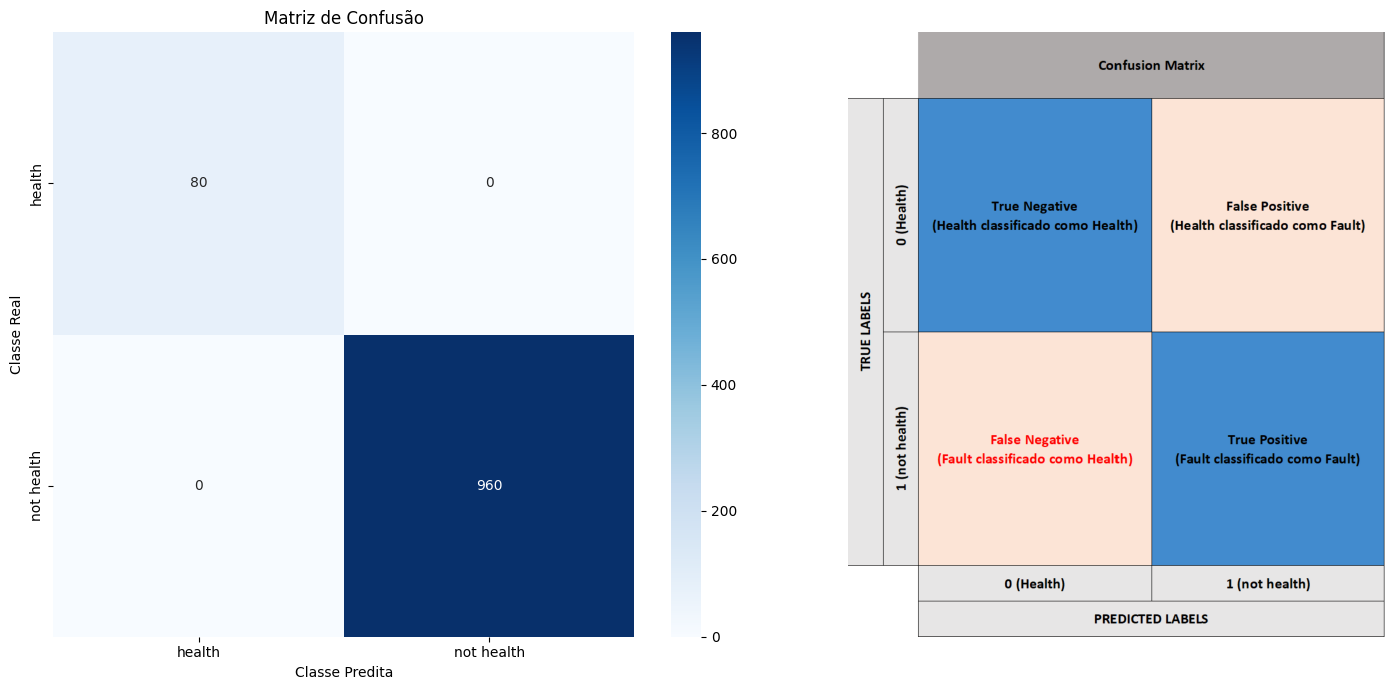

[[ 80   0]
 [  0 960]]
Accuracy: 100.00% para 15 features analisadas
Acurácia = resultados corretos/total (TN+TP)/(TN+TP+FN+FP)


In [15]:
def gerar_features_resposta_treino(n_features):
    df_top_features,binary_fault_dataframe = format_dataframe_features(df_features_org,n_features)
    #### #### Sistema  Especialista #### ####
    respostas_df,df_features_resposta  = apply_rules(df_top_features,"20Nm")
    # df_features_resposta = Da a resposta do sistema especialista "pred"
    return df_features_resposta 
df_features_resposta= gerar_features_resposta_treino(15)
cm_plot_didatico = plot_cm_didatica(df_features_resposta) # confusion matrix com imagem ilustrativa 

## Funções Plots

In [16]:
#### #### Plots #### ####
"""

# Plotagem histograma com limites de controle max_min health
plot_health_non_health_features(df_top_features,"20Nm")

# Plotagem scatter_plot com limites de controle max_min health
plot_health_non_health_scatter(df_top_features,"2-0Nm")

# Plotagem Kernel Density Estimate(KDE) com limites de controle max_min health
plot_health_non_health_kde(df_top_features, "2-0Nm")

## Plotagem Pair Plot ## visualização das relações 2-2 entre features
plot_health_non_health_pairplot(df_top_features)#, "2-0Nm")
        # gráfico ajustado entre 10/20 ou todos

# Plot 3D 3 features, talvez seja bonito colocar no relatório
plot_3d_health_non_health(df_top_features, "1-0Nm", top_3ft_list)
"""


'\n\n# Plotagem histograma com limites de controle max_min health\nplot_health_non_health_features(df_top_features,"20Nm")\n\n# Plotagem scatter_plot com limites de controle max_min health\nplot_health_non_health_scatter(df_top_features,"2-0Nm")\n\n# Plotagem Kernel Density Estimate(KDE) com limites de controle max_min health\nplot_health_non_health_kde(df_top_features, "2-0Nm")\n\n## Plotagem Pair Plot ## visualização das relações 2-2 entre features\nplot_health_non_health_pairplot(df_top_features)#, "2-0Nm")\n        # gráfico ajustado entre 10/20 ou todos\n\n# Plot 3D 3 features, talvez seja bonito colocar no relatório\nplot_3d_health_non_health(df_top_features, "1-0Nm", top_3ft_list)\n'

Features relevantes: (8 features)
- 1,2,3,4,7,10,11,14


# Resultados  Treinamento
- Usar 14 features, ele vai conseguir classificar tudo que é health e o resto é não health, 100% de acerto
  - Testar no conjunto de teste 

- Se eu for querer inverter as coisas, vai ficar mais difícil aumentar a precisão, inclusive mais features vai ser pior por causa do overfitting e pa, mostrar as duas análises no meu relatório

é muito mais simples e preciso ir pela análise 1: que me da 100% de acerto

Se ela me da 100% de acerto não preciso fazer o outro método ne kkkkk.
**Se ela não der 100% de acerto, no teste, ai faço o outro método.**

# Executar Conjunto de Teste

Estratégia: 
1. Mapear funções que vou usar
2. Puxar função 1 a 1 e mudar a referência do df_org para o df_teste
   1. Isso vou ter q mexer no apply rules se não me engano, generalizar mais ela
3. Ver se alguma função intermediária que não ta genérica e vai quebrar a parada
4. Pular as funções de análise de variáveis do treino, você só quer plotar os resultados
5. Executar e armazenar resultados

In [17]:
# Importando e criando basona teste
df_features_org_t = combine_features_datasets("todos","final",0.1) #treino,teste,todos ; inicial,final ; timeframe
df_features_org_t = df_features_org_t.drop(columns=redundant_ft_drop_list)

Columns [col] not found in [filename]
number of files geral = 23
combined files geral: ['gear_pitting_H_torque_circulation_2000rpm_10Nm.csv', 'gear_pitting_H_torque_circulation_2000rpm_20Nm.csv', 'gear_pitting_L_torque_circulation_2000rpm_10Nm.csv', 'gear_pitting_L_torque_circulation_2000rpm_20Nm.csv', 'gear_pitting_M_torque_circulation_2000rpm_10Nm.csv', 'gear_pitting_M_torque_circulation_2000rpm_20Nm.csv', 'gear_wear_H_torque_circulation_2000rpm_10Nm.csv', 'gear_wear_H_torque_circulation_2000rpm_20Nm.csv', 'gear_wear_L_torque_circulation_2000rpm_10Nm.csv', 'gear_wear_L_torque_circulation_2000rpm_20Nm.csv', 'gear_wear_M_torque_circulation_2000rpm_10Nm.csv', 'gear_wear_M_torque_circulation_2000rpm_20Nm.csv', 'teeth_break_H_torque_circulation_2000rpm_10Nm.csv', 'teeth_break_H_torque_circulation_2000rpm_20Nm.csv', 'teeth_break_L_torque_circulation_2000rpm_10Nm.csv', 'teeth_break_L_torque_circulation_2000rpm_20Nm.csv', 'teeth_break_M_torque_circulation_2000rpm_10Nm.csv', 'teeth_break_M_to

Observações:
- não vou usar .corr() para relacionar features, vou filtrar as mesmas to treino

In [18]:
# Salvando as variáveis treino
#### #### formatação #### ####
def gerar_features_resposta_teste(n_features): 
    df_top_features,binary_fault_dataframe = format_dataframe_features(df_features_org,n_features)
    #### #### Sistema  Especialista #### ####
    respostas_df,df_features_resposta  = apply_rules(df_top_features,"20Nm")
    # Rodando funções Foco Teste ('_t')

    #### #### formatação #### #### 
    normalized_dataframe_t = normalize_data(df_features_org_t)
    binary_fault_dataframe_t = fault_to_binary(normalized_dataframe_t)
        # pegar features do treino
    top_ft_list = top_features_list(binary_fault_dataframe,n_features) #pegando as features do treino
        # aplicar features do treino no df teste
    df_top_features_t = filter_top_features_df(binary_fault_dataframe_t,top_ft_list)
    # ok até aqui
    #### #### Sistema  Especialista #### ####
    respostas_df_t,df_features_resposta_t  = apply_regras_teste(df_top_features,df_top_features_t,"20Nm")
 
    return df_features_resposta_t
df_features_resposta_t = gerar_features_resposta_teste(4)
#plot_cm_teste = plot_cm_didatica(df_features_resposta_t)
df_features_resposta_t

,gearbox_vibration_x.shape_factor,gearbox_vibration_x.std,gearbox_vibration_z.shape_factor,gearbox_vibration_x.kurtosis,Fault,Torque,Resposta SE
79,0.316864,0.500382,0.166261,0.249864,not health,20Nm,not health
80,0.202052,0.547468,0.098961,0.132205,not health,20Nm,not health
81,0.253032,0.505565,0.106745,0.194099,not health,20Nm,not health
82,0.233742,0.453448,0.120473,0.228370,not health,20Nm,not health
83,0.202647,0.551501,0.067101,0.142724,not health,20Nm,not health
...,...,...,...,...,...,...,...
2128,0.570190,0.674023,0.812610,0.832745,not health,20Nm,not health
2129,0.325524,0.638717,0.436137,0.324984,not health,20Nm,not health
2130,0.459635,0.670625,0.601545,0.566769,not health,20Nm,not health
2131,0.428210,0.674214,0.664765,0.359025,not health,20Nm,not health


# Fim Ciclo 1
## Resultados
- O sistema especialista com a maior precisão é o que classifca tudo como falha o tempo todo (14+)
- Não tem nenhuma utilidade kkkkkkkkk
- EU TENHO QUE PARAMETRIZAR A RELAÇÃO FALHA VS SAUDÁVEL
DEVIDO AO MEU SISTEMA TAR 4X MAIS FALHAS QUE SAUDÁVEIS, O RESULTADO MAIS OPTIMIZADO SEMPRE VAI SER O QUE A FALHA ACERTA, E FODASE O SAUDÁVEL

* O CORRETO SERIA CADA UMA DELAS TER PESO 50%
  * Além de 

# Evaluating the model correctly

# Mágica gpt, vmo ver

Function to calculate evaluation metrics

In [19]:
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, roc_curve, roc_auc_score

def plot_confusion_matrix(y_true, y_pred, labels):
    fig, ax = plt.subplots(figsize=(15, 7))
    
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    
    # Plot the confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_xlabel('Classe Predita')
    ax.set_ylabel('Classe Real')
    ax.set_title('Matriz de Confusão')
    
    plt.tight_layout()
    plt.show()
    
    return cm

def calculate_metrics(y_true, y_pred,cm, labels):
    #cm = confusion_matrix(y_true, y_pred, labels=labels)
    accuracy = np.trace(cm) / np.sum(cm)
    precision = precision_score(y_true, y_pred, pos_label='health',average='macro') #avaliar o correto
    recall = recall_score(y_true, y_pred, pos_label='health',average='macro')
    f1 = f1_score(y_true, y_pred, pos_label='health',average='macro')
    
    print(f'Accuracy: {accuracy:.2%}')
    print(f'Precision: {precision:.2%}')
    print(f'Recall: {recall:.2%}')
    print(f'F1 Score: {f1:.2%}')
    print(classification_report(y_true, y_pred, target_names=labels))

    return accuracy, precision, recall, f1

def plot_roc_curve(y_true, y_prob, pos_label):
    fpr, tpr, _ = roc_curve(y_true, y_prob, pos_label=pos_label)
    auc = roc_auc_score(y_true, y_prob)
    
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

def evaluate_model(features_resposta):
    y_true = features_resposta['Fault']
    y_pred = features_resposta['Resposta SE']
    labels = ['health', 'not health']
    
    cm = plot_confusion_matrix(y_true, y_pred, labels)
    accuracy, precision, recall, f1 = calculate_metrics(y_true, y_pred,cm, labels)
    
    if 'Prob' in features_resposta.columns:  # Assuming you have probability scores
        y_prob = features_resposta['Prob']
        #plot_roc_curve(y_true, y_prob, pos_label='health')
    #else:
        #print("Probability scores not found in features_resposta DataFrame.")
    
    # Select numeric types from the DataFrame
    df_features_n = features_resposta.select_dtypes(include=['float64', 'int64']) #selecionar as colunas da feature respostas que são numéricas: colunas de features
    print(f'{len(df_features_n.columns)} features analisadas')
    
# Example usage
# Assuming features_resposta is your DataFrame

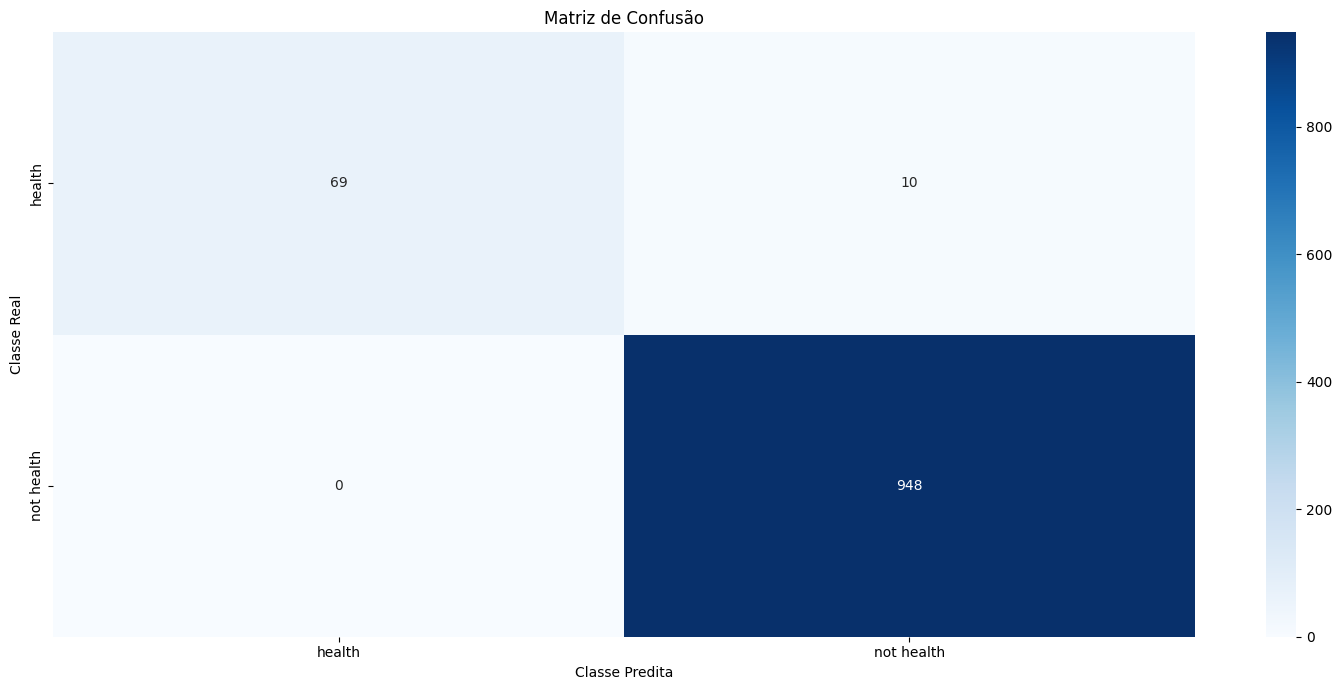

Accuracy: 99.03%
Precision: 99.48%
Recall: 93.67%
F1 Score: 96.36%
              precision    recall  f1-score   support

      health       1.00      0.87      0.93        79
  not health       0.99      1.00      0.99       948

    accuracy                           0.99      1027
   macro avg       0.99      0.94      0.96      1027
weighted avg       0.99      0.99      0.99      1027

7 features analisadas


In [20]:
#for n in range(1,41):
n=7
df_features_resposta = gerar_features_resposta_treino(n)
df_features_resposta_t = gerar_features_resposta_teste(n) #melhor = 7
evaluate_model(df_features_resposta_t)

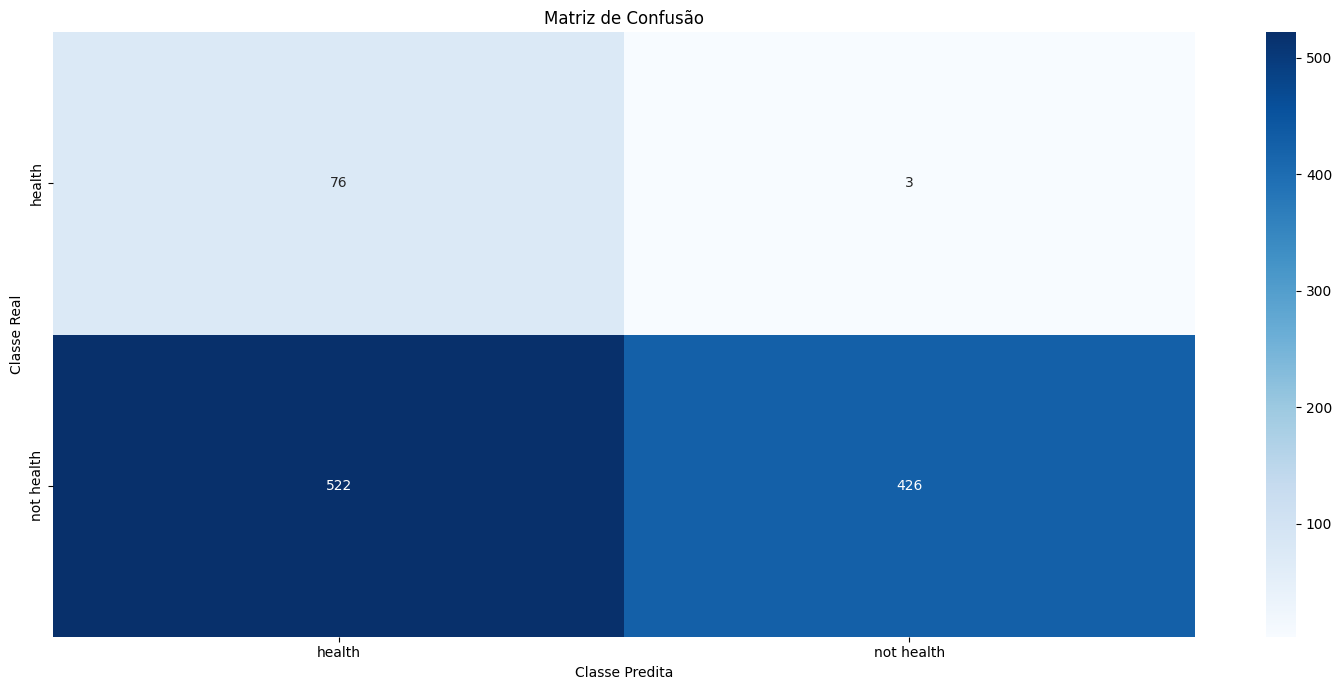

Accuracy: 48.88%
Precision: 56.00%
Recall: 70.57%
F1 Score: 42.16%
              precision    recall  f1-score   support

      health       0.13      0.96      0.22        79
  not health       0.99      0.45      0.62       948

    accuracy                           0.49      1027
   macro avg       0.56      0.71      0.42      1027
weighted avg       0.93      0.49      0.59      1027

1 features analisadas


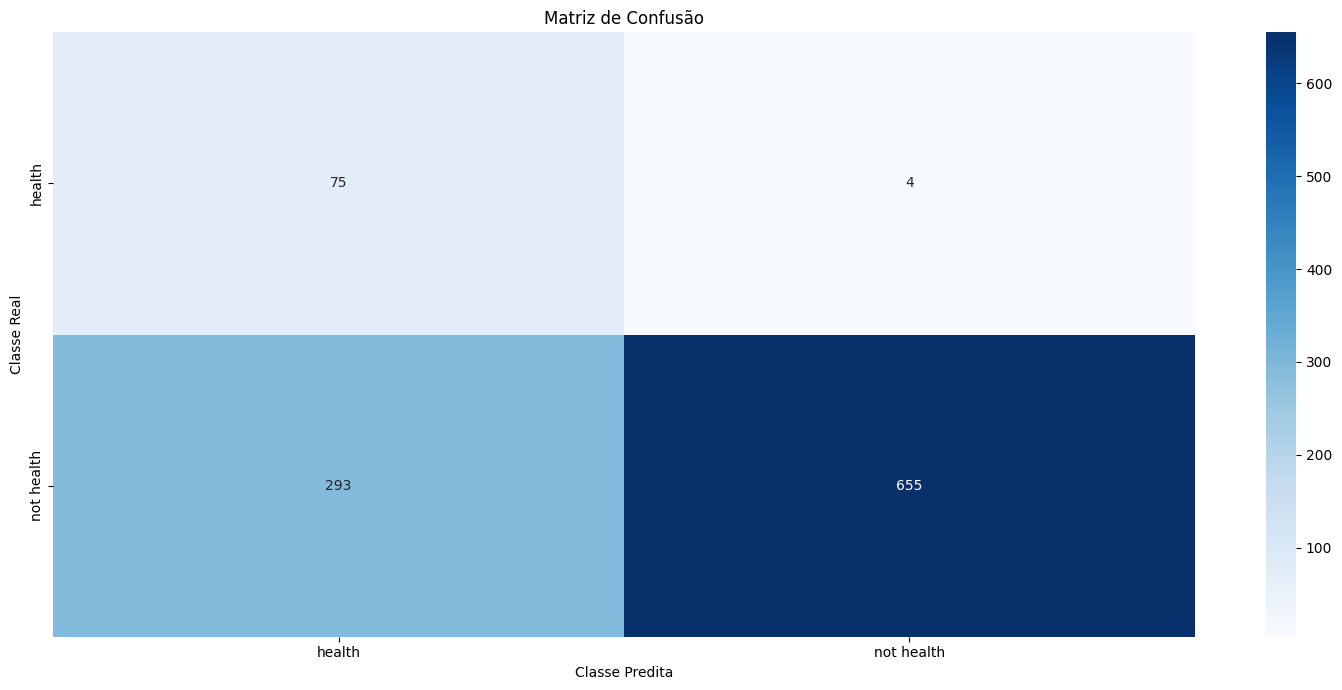

Accuracy: 71.08%
Precision: 59.89%
Recall: 82.01%
F1 Score: 57.54%
              precision    recall  f1-score   support

      health       0.20      0.95      0.34        79
  not health       0.99      0.69      0.82       948

    accuracy                           0.71      1027
   macro avg       0.60      0.82      0.58      1027
weighted avg       0.93      0.71      0.78      1027

2 features analisadas


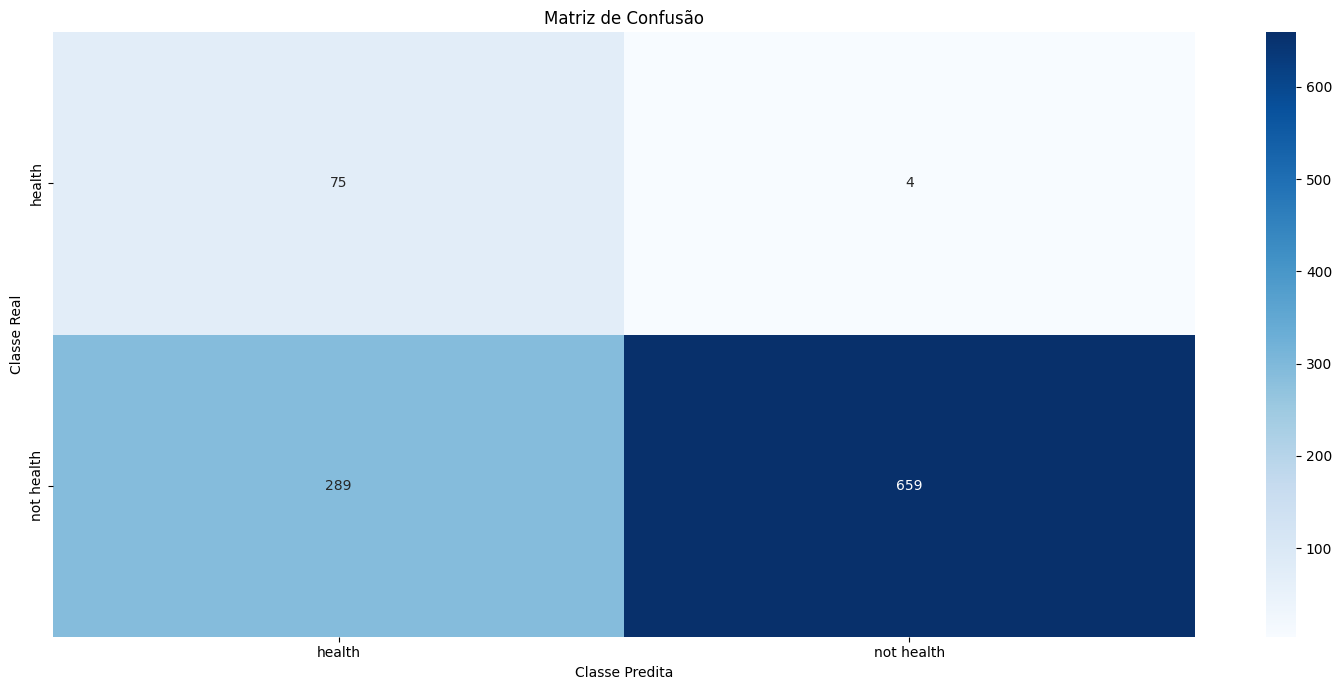

Accuracy: 71.47%
Precision: 60.00%
Recall: 82.23%
F1 Score: 57.84%
              precision    recall  f1-score   support

      health       0.21      0.95      0.34        79
  not health       0.99      0.70      0.82       948

    accuracy                           0.71      1027
   macro avg       0.60      0.82      0.58      1027
weighted avg       0.93      0.71      0.78      1027

3 features analisadas


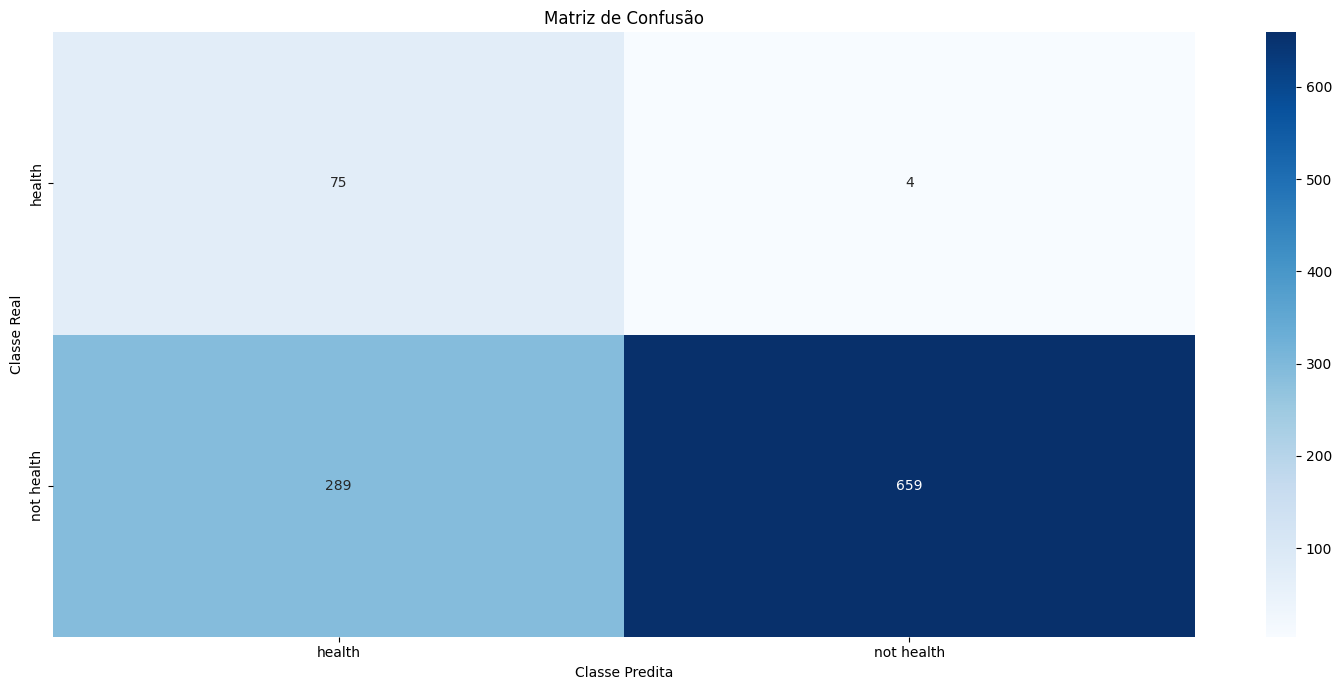

Accuracy: 71.47%
Precision: 60.00%
Recall: 82.23%
F1 Score: 57.84%
              precision    recall  f1-score   support

      health       0.21      0.95      0.34        79
  not health       0.99      0.70      0.82       948

    accuracy                           0.71      1027
   macro avg       0.60      0.82      0.58      1027
weighted avg       0.93      0.71      0.78      1027

4 features analisadas


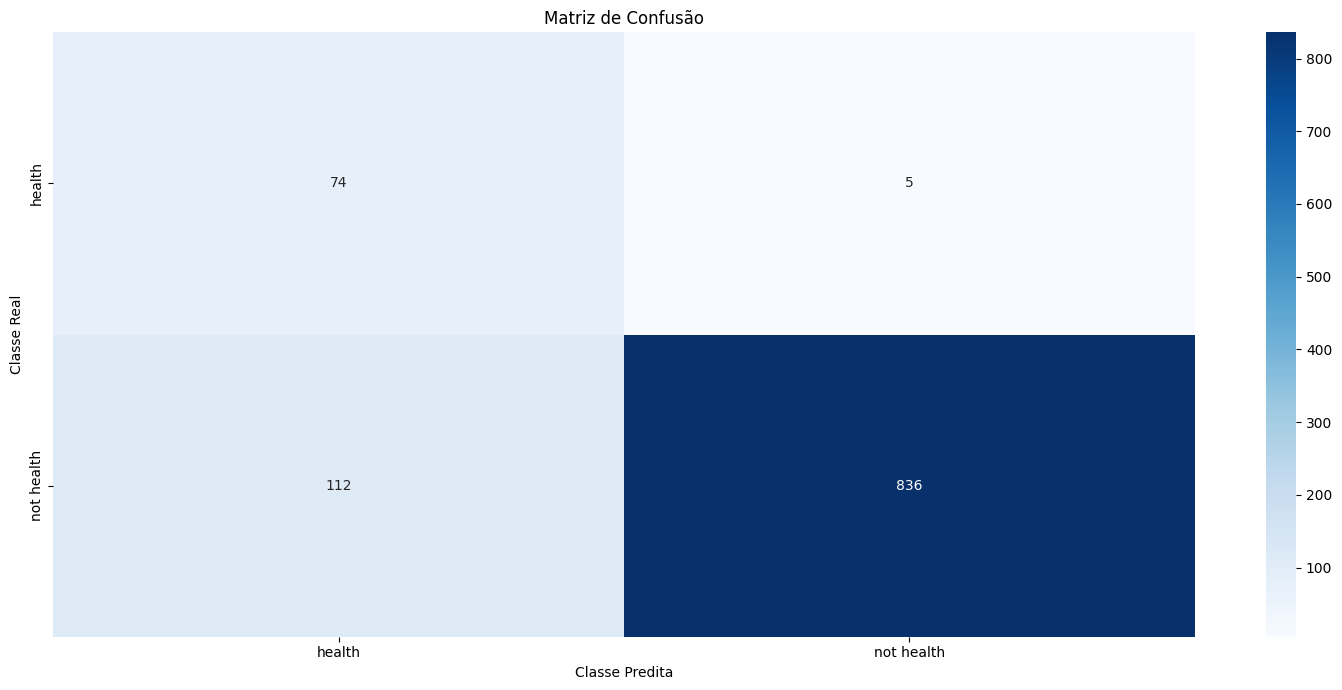

Accuracy: 88.61%
Precision: 69.60%
Recall: 90.93%
F1 Score: 74.65%
              precision    recall  f1-score   support

      health       0.40      0.94      0.56        79
  not health       0.99      0.88      0.93       948

    accuracy                           0.89      1027
   macro avg       0.70      0.91      0.75      1027
weighted avg       0.95      0.89      0.91      1027

5 features analisadas


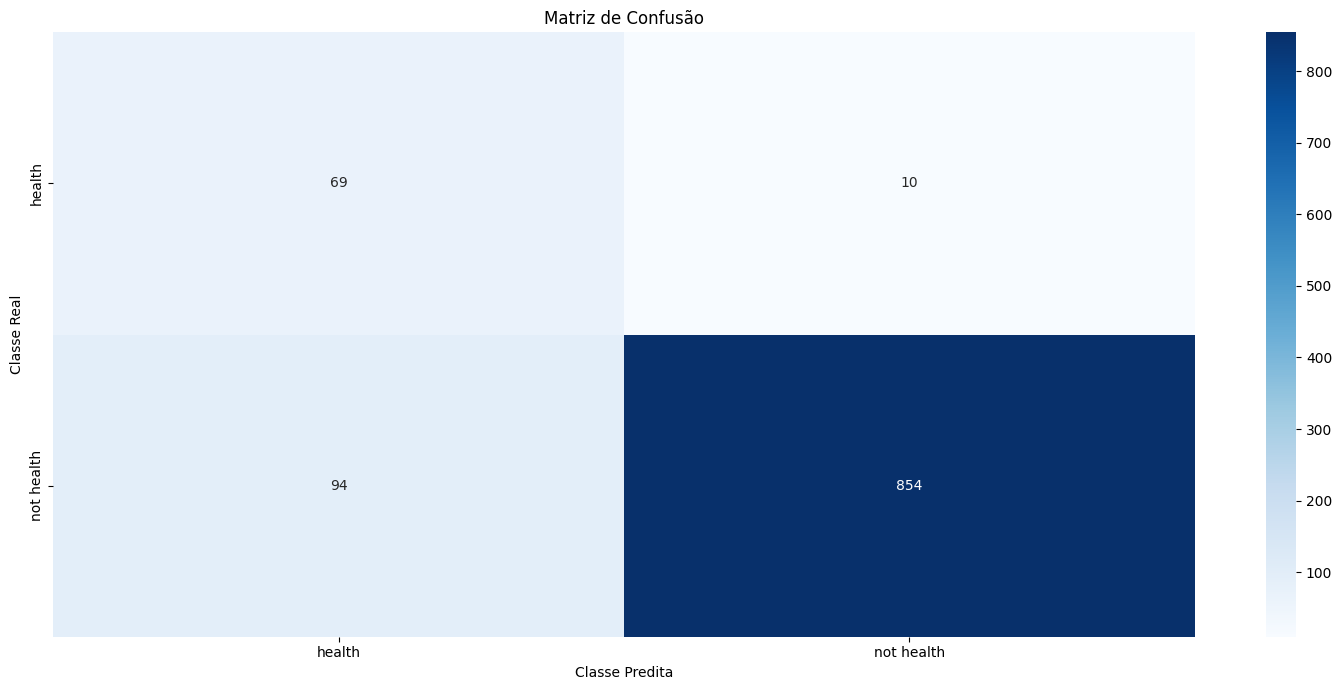

Accuracy: 89.87%
Precision: 70.59%
Recall: 88.71%
F1 Score: 75.64%
              precision    recall  f1-score   support

      health       0.42      0.87      0.57        79
  not health       0.99      0.90      0.94       948

    accuracy                           0.90      1027
   macro avg       0.71      0.89      0.76      1027
weighted avg       0.94      0.90      0.91      1027

6 features analisadas


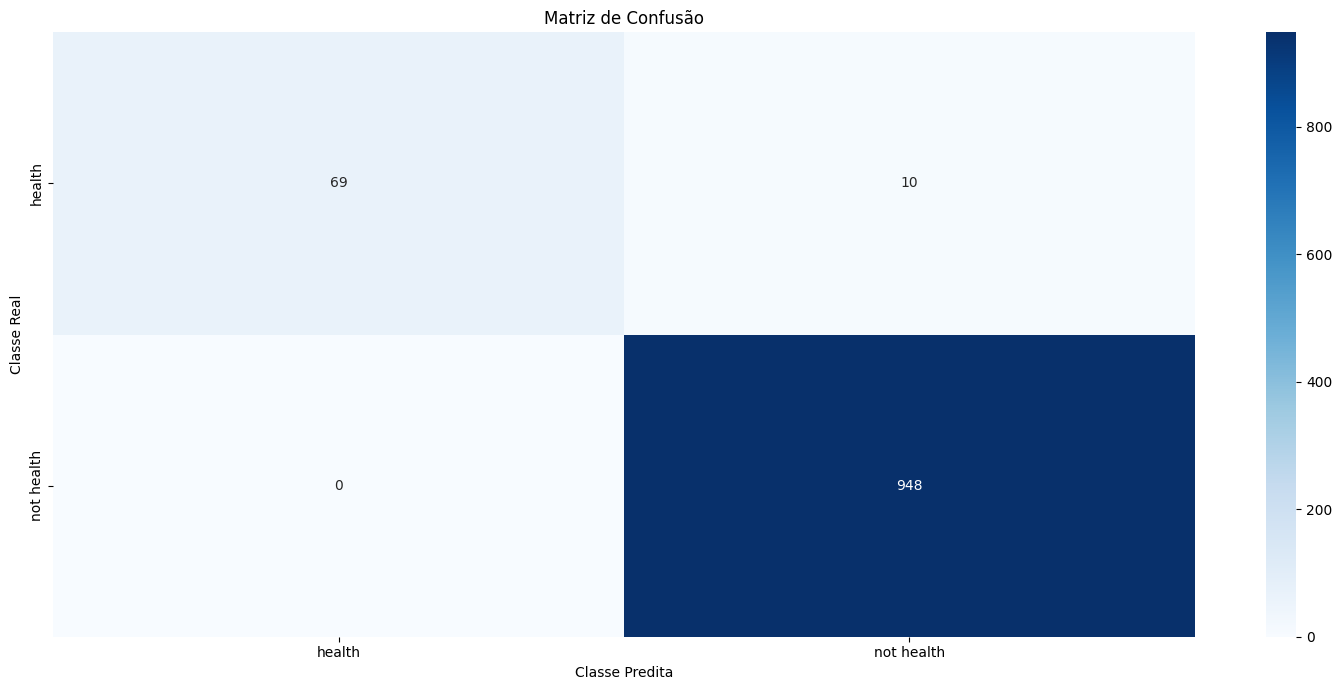

Accuracy: 99.03%
Precision: 99.48%
Recall: 93.67%
F1 Score: 96.36%
              precision    recall  f1-score   support

      health       1.00      0.87      0.93        79
  not health       0.99      1.00      0.99       948

    accuracy                           0.99      1027
   macro avg       0.99      0.94      0.96      1027
weighted avg       0.99      0.99      0.99      1027

7 features analisadas


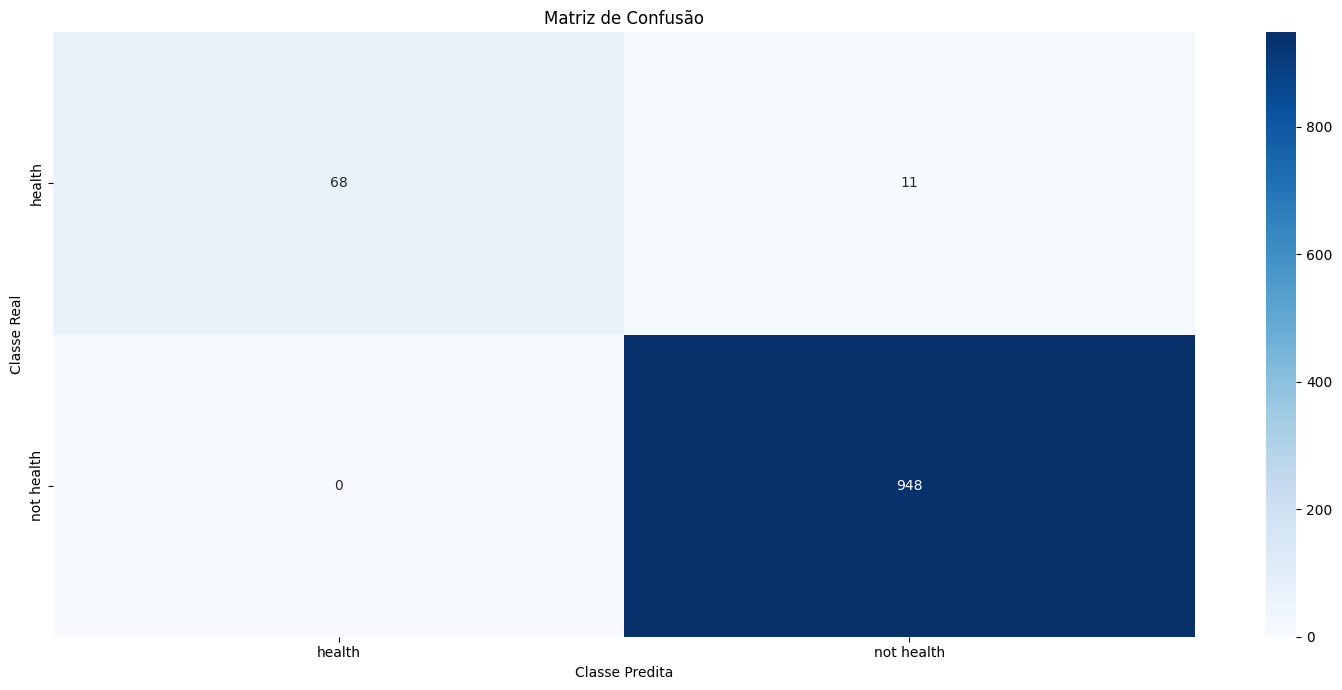

Accuracy: 98.93%
Precision: 99.43%
Recall: 93.04%
F1 Score: 95.97%
              precision    recall  f1-score   support

      health       1.00      0.86      0.93        79
  not health       0.99      1.00      0.99       948

    accuracy                           0.99      1027
   macro avg       0.99      0.93      0.96      1027
weighted avg       0.99      0.99      0.99      1027

8 features analisadas


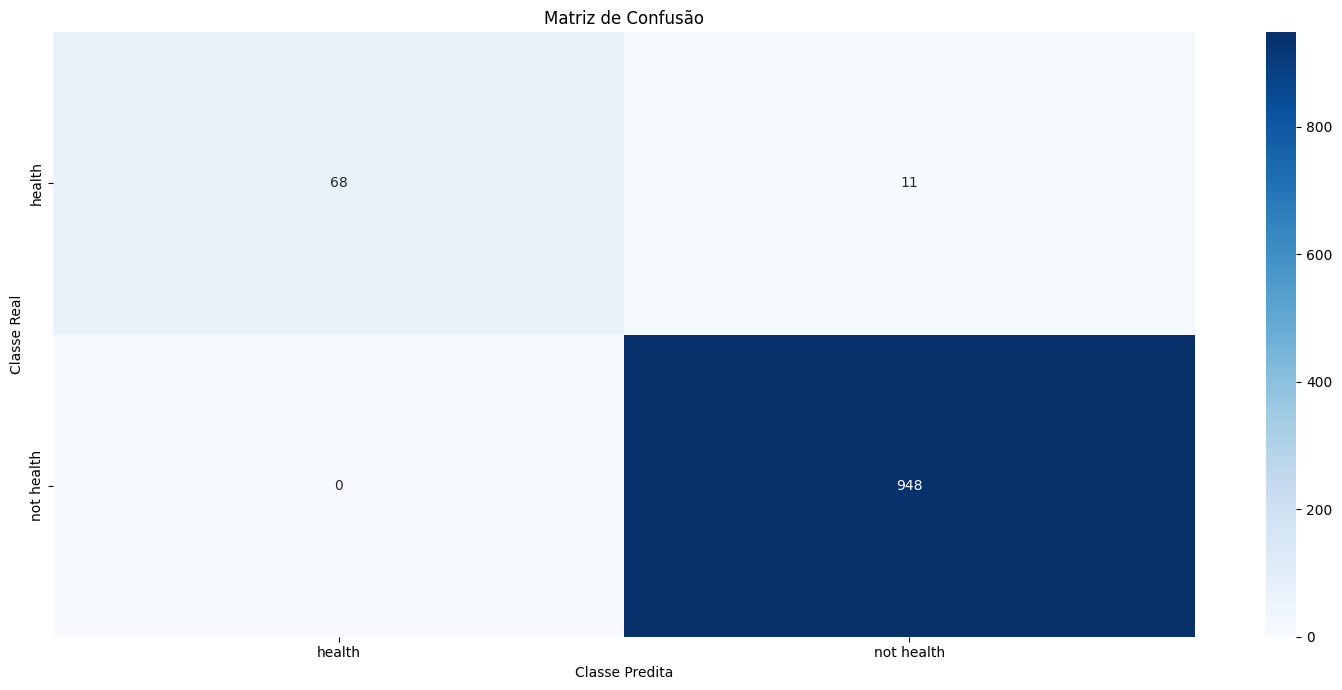

Accuracy: 98.93%
Precision: 99.43%
Recall: 93.04%
F1 Score: 95.97%
              precision    recall  f1-score   support

      health       1.00      0.86      0.93        79
  not health       0.99      1.00      0.99       948

    accuracy                           0.99      1027
   macro avg       0.99      0.93      0.96      1027
weighted avg       0.99      0.99      0.99      1027

9 features analisadas


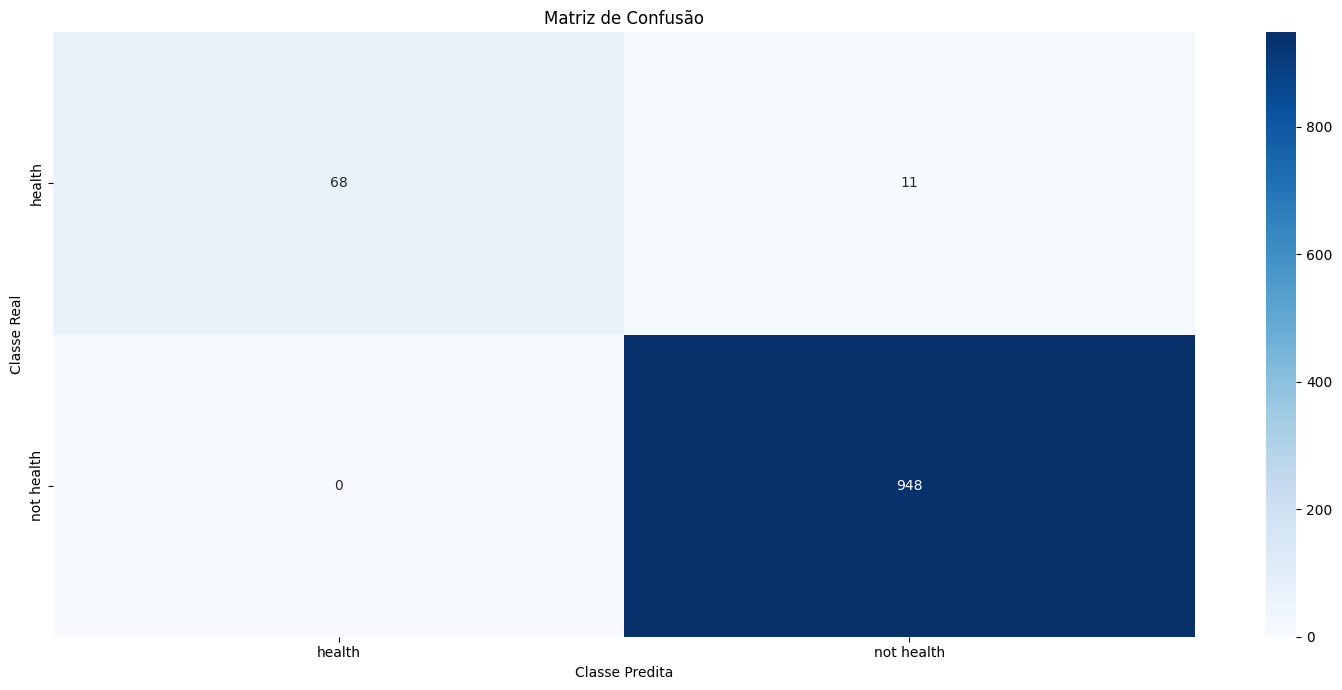

Accuracy: 98.93%
Precision: 99.43%
Recall: 93.04%
F1 Score: 95.97%
              precision    recall  f1-score   support

      health       1.00      0.86      0.93        79
  not health       0.99      1.00      0.99       948

    accuracy                           0.99      1027
   macro avg       0.99      0.93      0.96      1027
weighted avg       0.99      0.99      0.99      1027

10 features analisadas


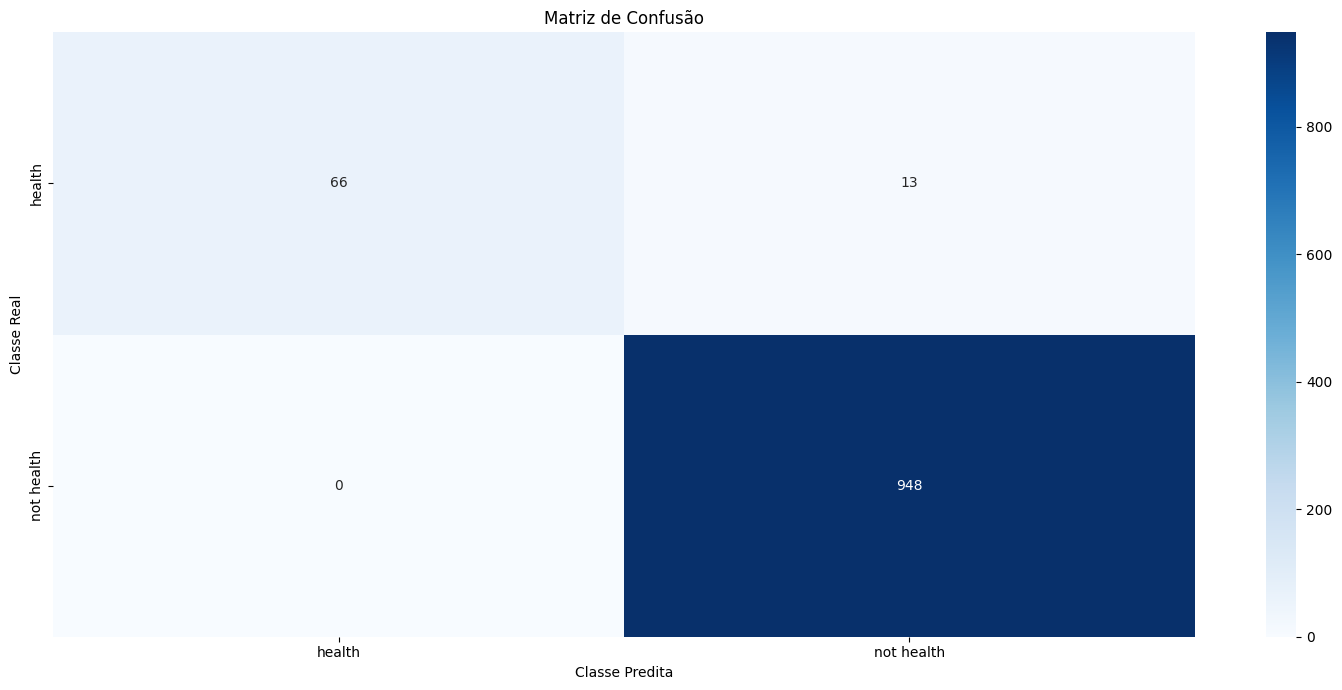

Accuracy: 98.73%
Precision: 99.32%
Recall: 91.77%
F1 Score: 95.18%
              precision    recall  f1-score   support

      health       1.00      0.84      0.91        79
  not health       0.99      1.00      0.99       948

    accuracy                           0.99      1027
   macro avg       0.99      0.92      0.95      1027
weighted avg       0.99      0.99      0.99      1027

11 features analisadas


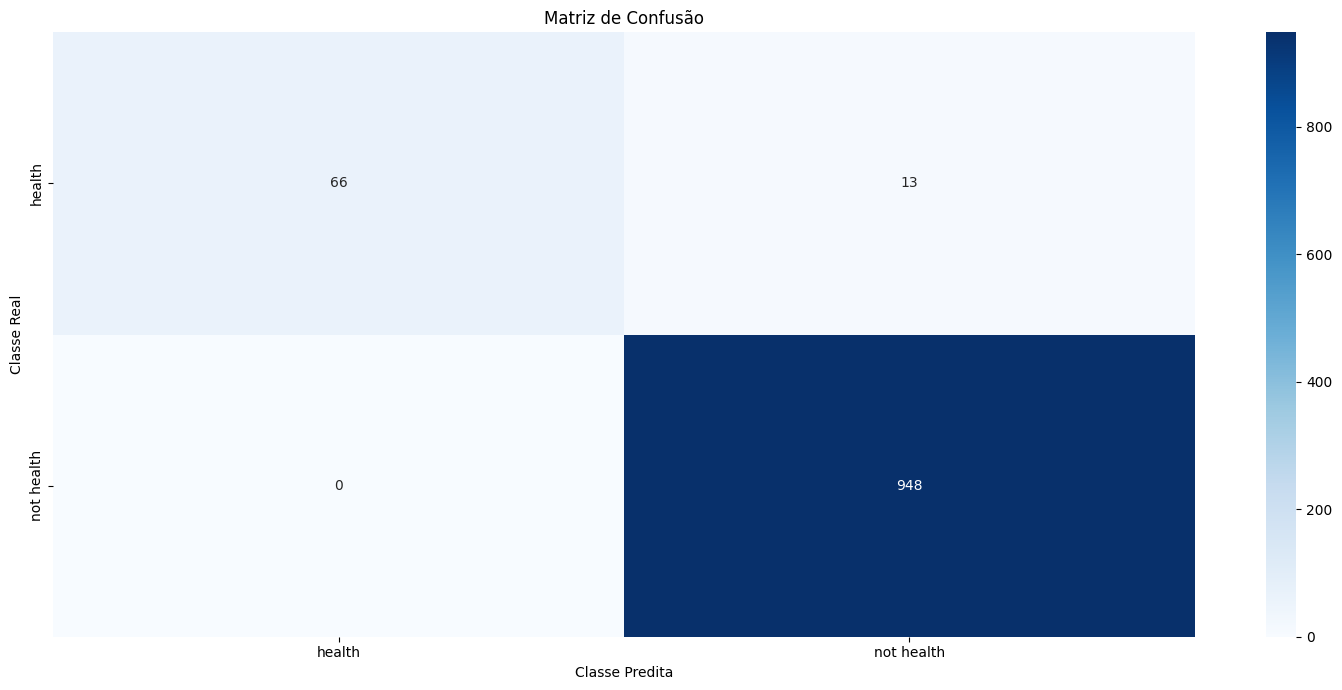

Accuracy: 98.73%
Precision: 99.32%
Recall: 91.77%
F1 Score: 95.18%
              precision    recall  f1-score   support

      health       1.00      0.84      0.91        79
  not health       0.99      1.00      0.99       948

    accuracy                           0.99      1027
   macro avg       0.99      0.92      0.95      1027
weighted avg       0.99      0.99      0.99      1027

12 features analisadas


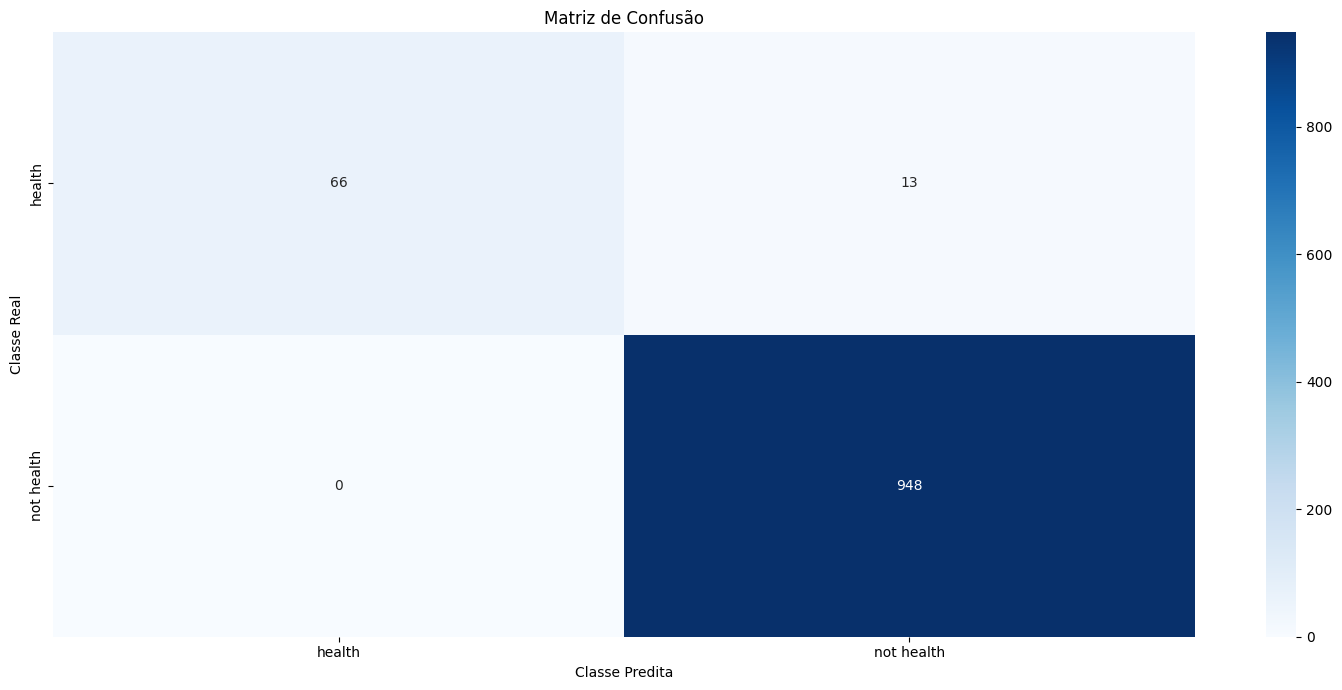

Accuracy: 98.73%
Precision: 99.32%
Recall: 91.77%
F1 Score: 95.18%
              precision    recall  f1-score   support

      health       1.00      0.84      0.91        79
  not health       0.99      1.00      0.99       948

    accuracy                           0.99      1027
   macro avg       0.99      0.92      0.95      1027
weighted avg       0.99      0.99      0.99      1027

13 features analisadas


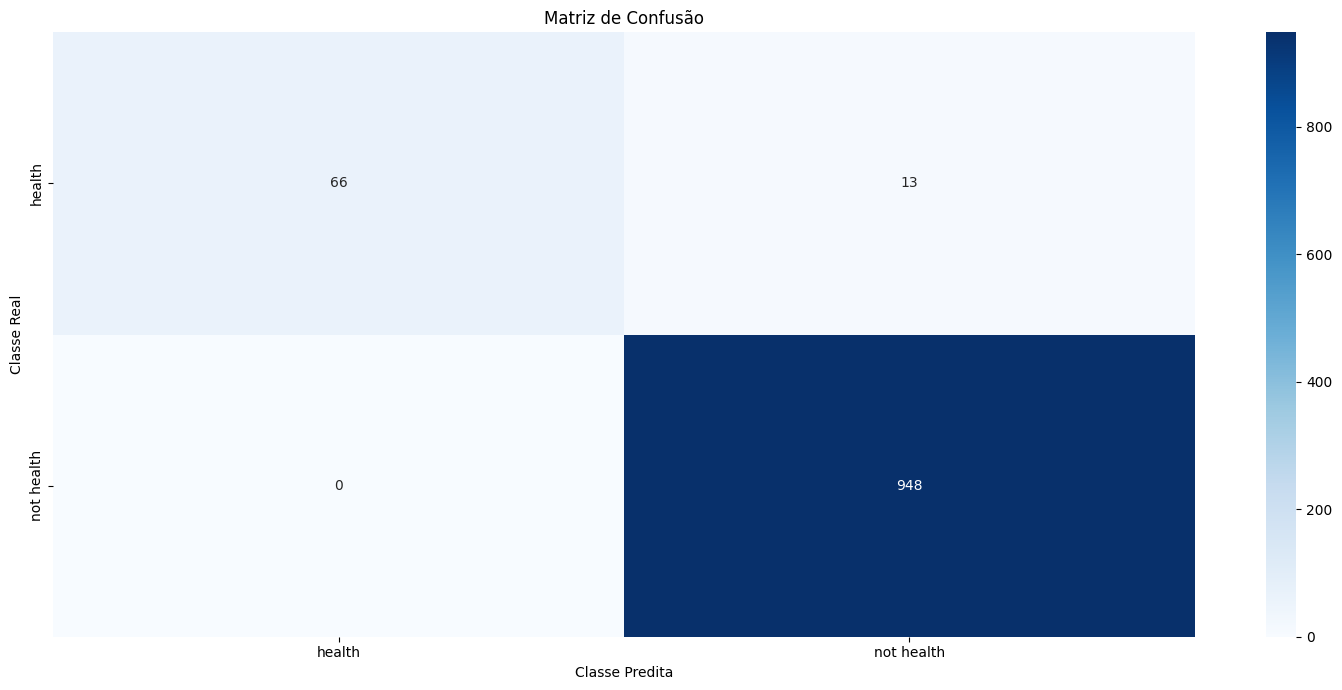

Accuracy: 98.73%
Precision: 99.32%
Recall: 91.77%
F1 Score: 95.18%
              precision    recall  f1-score   support

      health       1.00      0.84      0.91        79
  not health       0.99      1.00      0.99       948

    accuracy                           0.99      1027
   macro avg       0.99      0.92      0.95      1027
weighted avg       0.99      0.99      0.99      1027

14 features analisadas


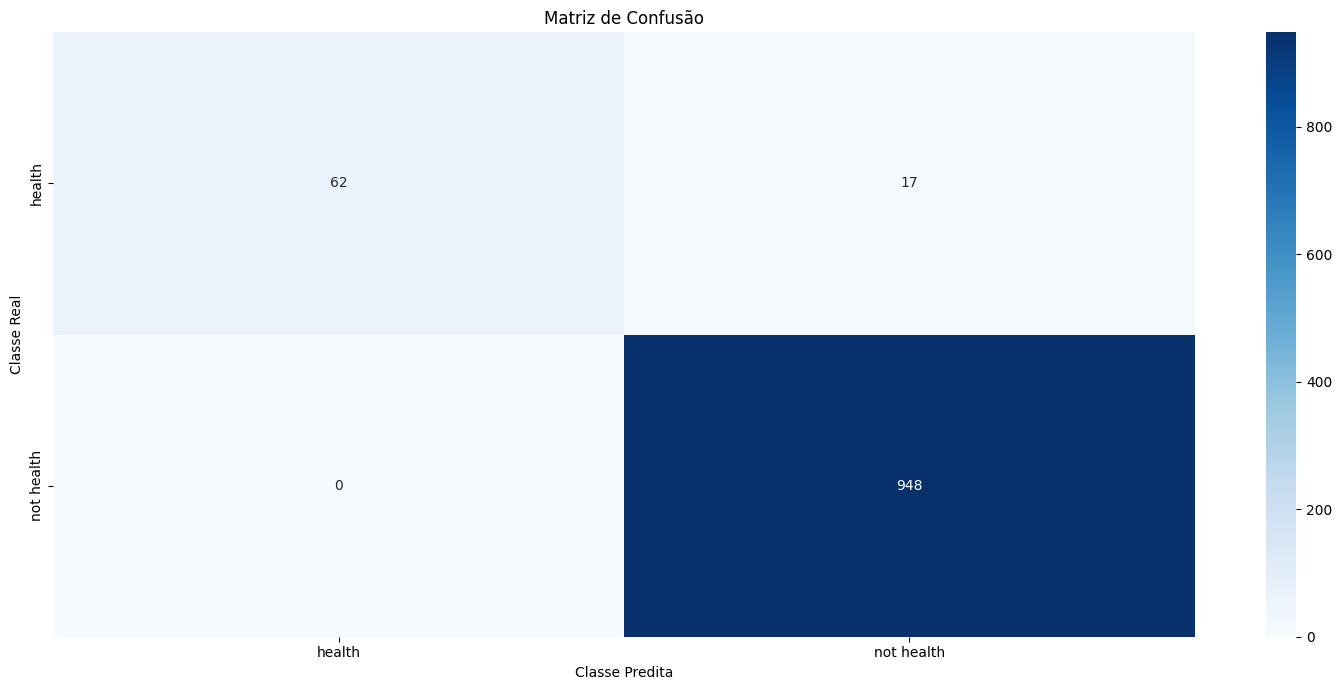

Accuracy: 98.34%
Precision: 99.12%
Recall: 89.24%
F1 Score: 93.53%
              precision    recall  f1-score   support

      health       1.00      0.78      0.88        79
  not health       0.98      1.00      0.99       948

    accuracy                           0.98      1027
   macro avg       0.99      0.89      0.94      1027
weighted avg       0.98      0.98      0.98      1027

15 features analisadas


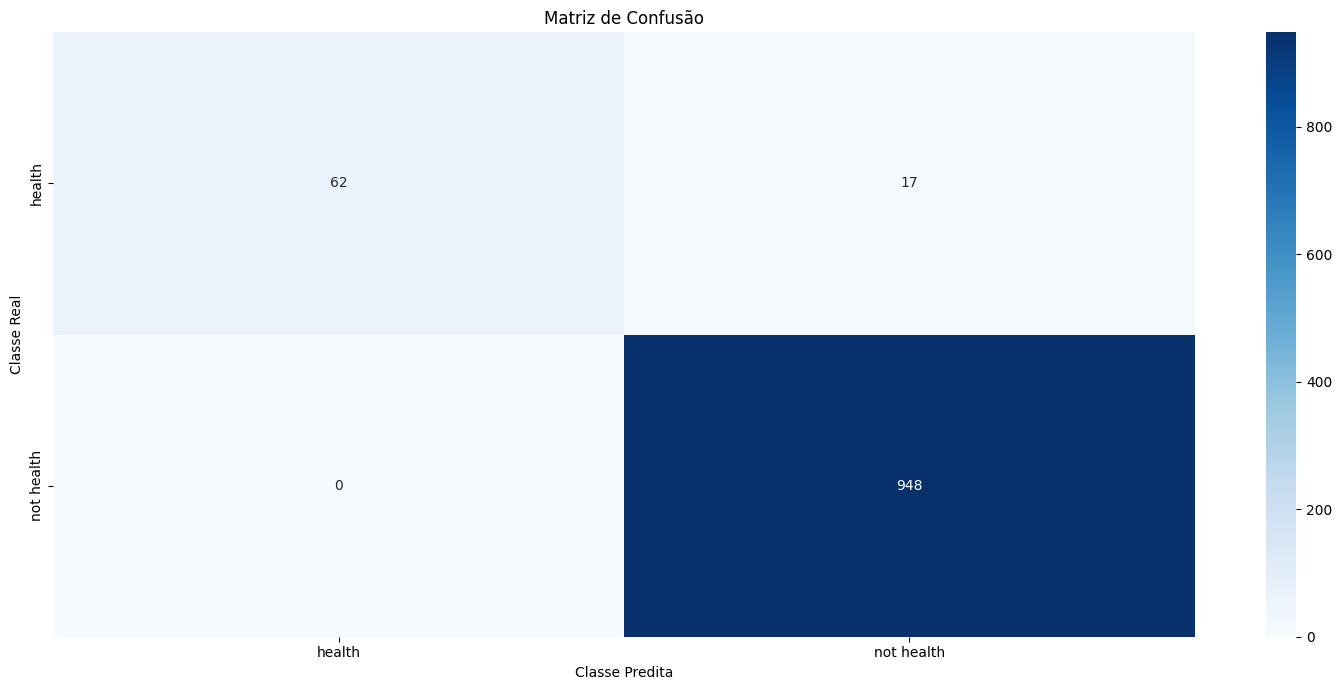

Accuracy: 98.34%
Precision: 99.12%
Recall: 89.24%
F1 Score: 93.53%
              precision    recall  f1-score   support

      health       1.00      0.78      0.88        79
  not health       0.98      1.00      0.99       948

    accuracy                           0.98      1027
   macro avg       0.99      0.89      0.94      1027
weighted avg       0.98      0.98      0.98      1027

16 features analisadas


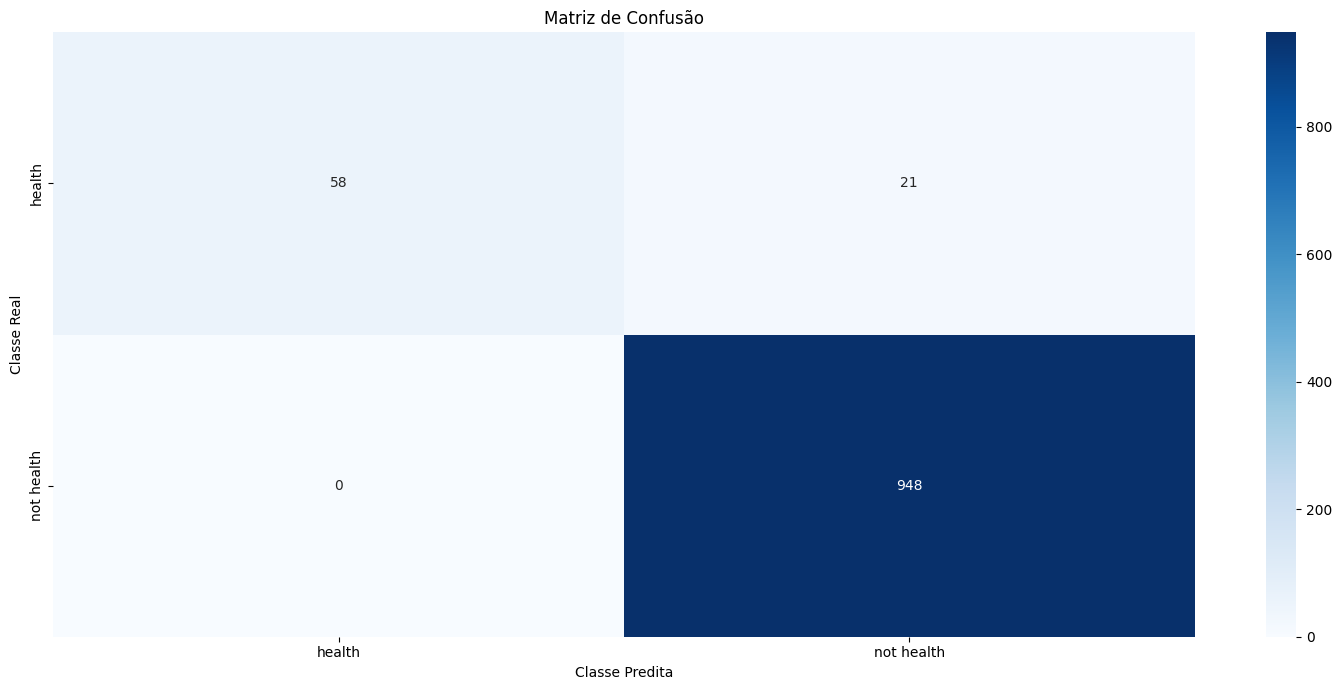

Accuracy: 97.96%
Precision: 98.92%
Recall: 86.71%
F1 Score: 91.79%
              precision    recall  f1-score   support

      health       1.00      0.73      0.85        79
  not health       0.98      1.00      0.99       948

    accuracy                           0.98      1027
   macro avg       0.99      0.87      0.92      1027
weighted avg       0.98      0.98      0.98      1027

17 features analisadas


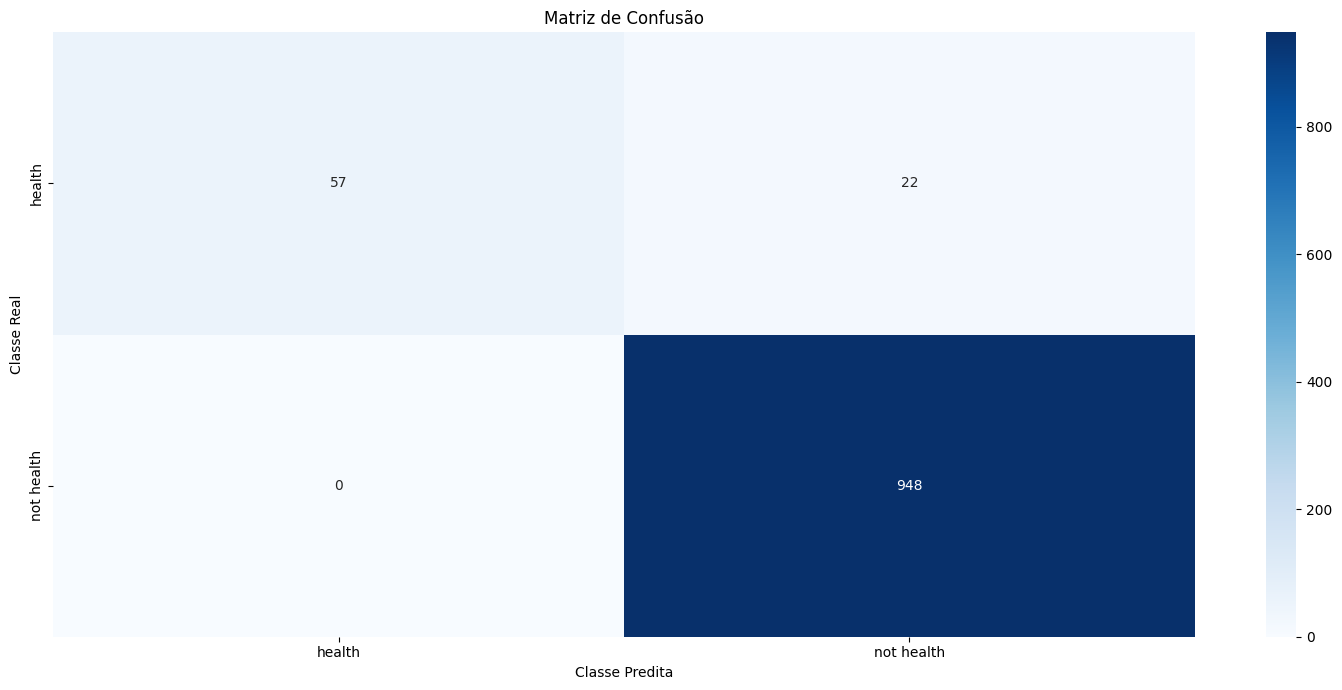

Accuracy: 97.86%
Precision: 98.87%
Recall: 86.08%
F1 Score: 91.34%
              precision    recall  f1-score   support

      health       1.00      0.72      0.84        79
  not health       0.98      1.00      0.99       948

    accuracy                           0.98      1027
   macro avg       0.99      0.86      0.91      1027
weighted avg       0.98      0.98      0.98      1027

18 features analisadas


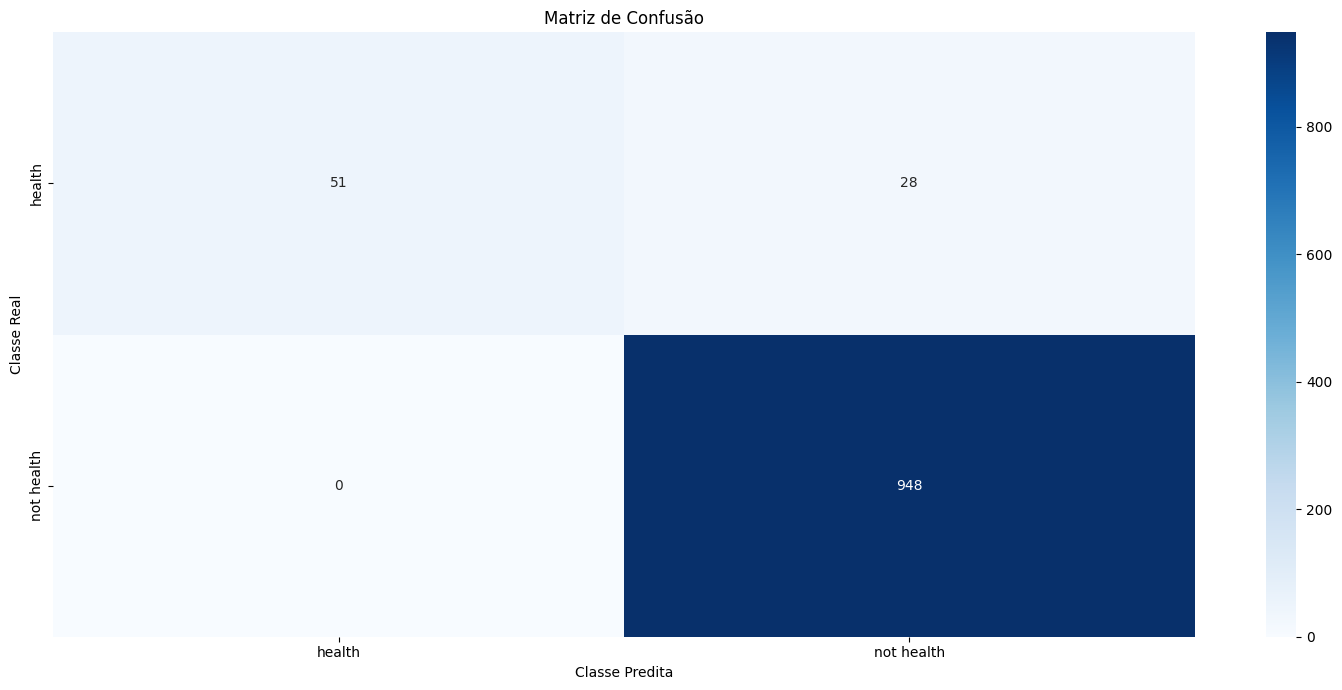

Accuracy: 97.27%
Precision: 98.57%
Recall: 82.28%
F1 Score: 88.50%
              precision    recall  f1-score   support

      health       1.00      0.65      0.78        79
  not health       0.97      1.00      0.99       948

    accuracy                           0.97      1027
   macro avg       0.99      0.82      0.89      1027
weighted avg       0.97      0.97      0.97      1027

19 features analisadas


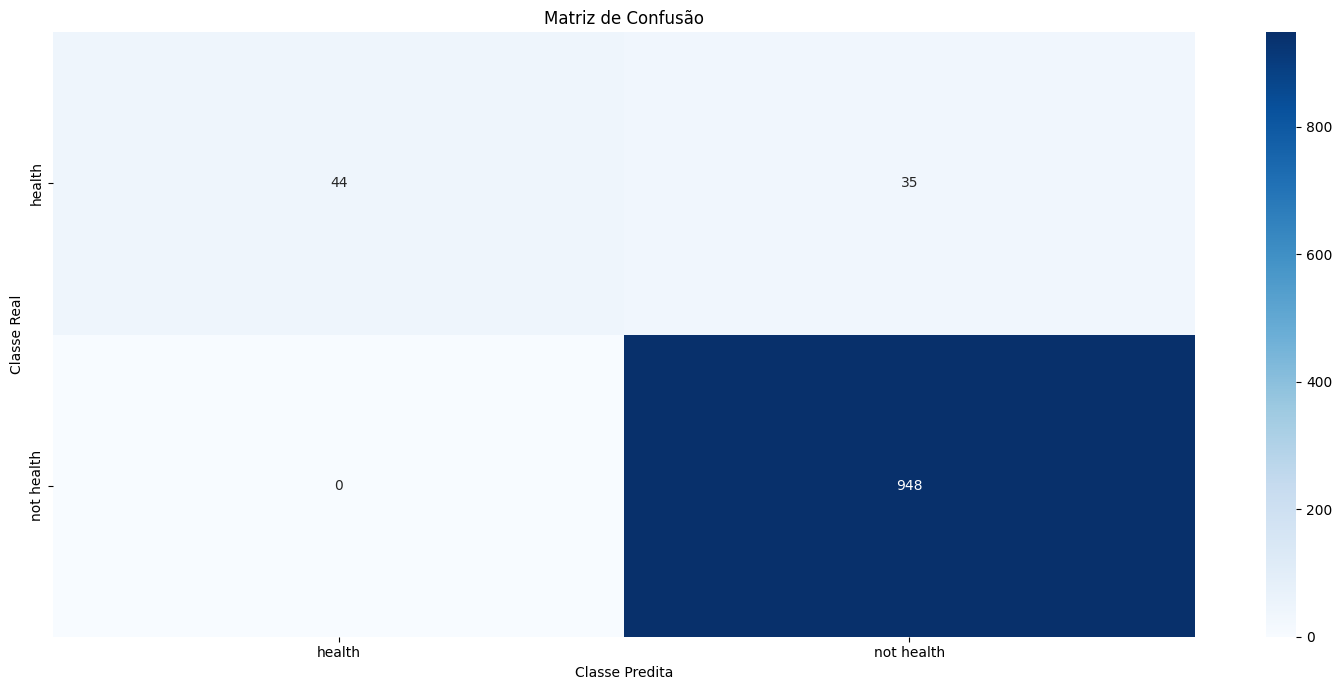

Accuracy: 96.59%
Precision: 98.22%
Recall: 77.85%
F1 Score: 84.87%
              precision    recall  f1-score   support

      health       1.00      0.56      0.72        79
  not health       0.96      1.00      0.98       948

    accuracy                           0.97      1027
   macro avg       0.98      0.78      0.85      1027
weighted avg       0.97      0.97      0.96      1027

20 features analisadas


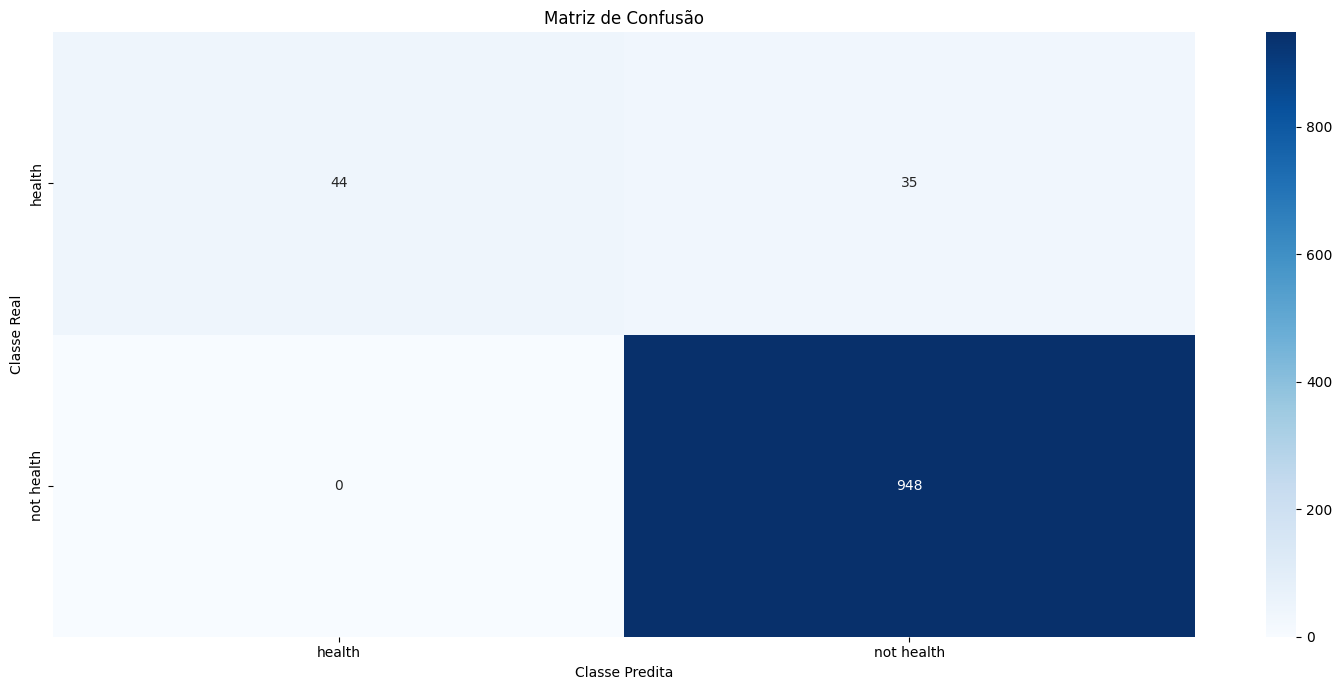

Accuracy: 96.59%
Precision: 98.22%
Recall: 77.85%
F1 Score: 84.87%
              precision    recall  f1-score   support

      health       1.00      0.56      0.72        79
  not health       0.96      1.00      0.98       948

    accuracy                           0.97      1027
   macro avg       0.98      0.78      0.85      1027
weighted avg       0.97      0.97      0.96      1027

21 features analisadas


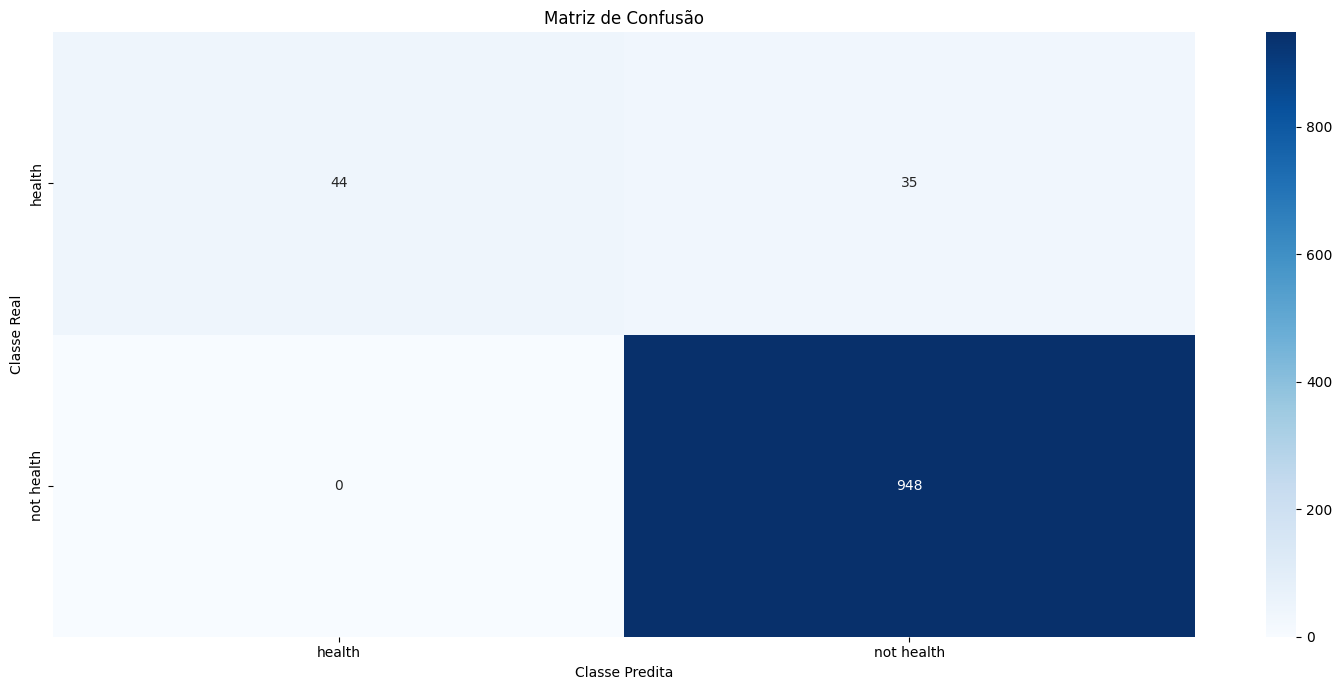

Accuracy: 96.59%
Precision: 98.22%
Recall: 77.85%
F1 Score: 84.87%
              precision    recall  f1-score   support

      health       1.00      0.56      0.72        79
  not health       0.96      1.00      0.98       948

    accuracy                           0.97      1027
   macro avg       0.98      0.78      0.85      1027
weighted avg       0.97      0.97      0.96      1027

22 features analisadas


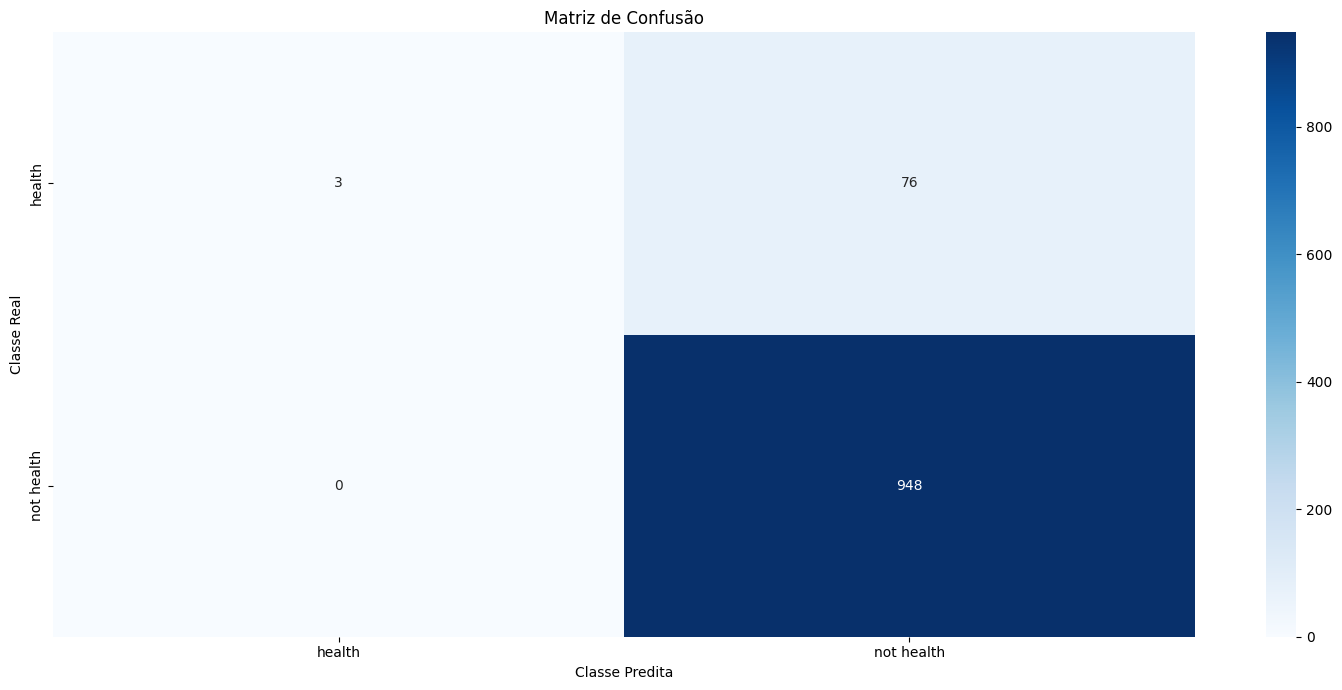

Accuracy: 92.60%
Precision: 96.29%
Recall: 51.90%
F1 Score: 51.73%
              precision    recall  f1-score   support

      health       1.00      0.04      0.07        79
  not health       0.93      1.00      0.96       948

    accuracy                           0.93      1027
   macro avg       0.96      0.52      0.52      1027
weighted avg       0.93      0.93      0.89      1027

23 features analisadas


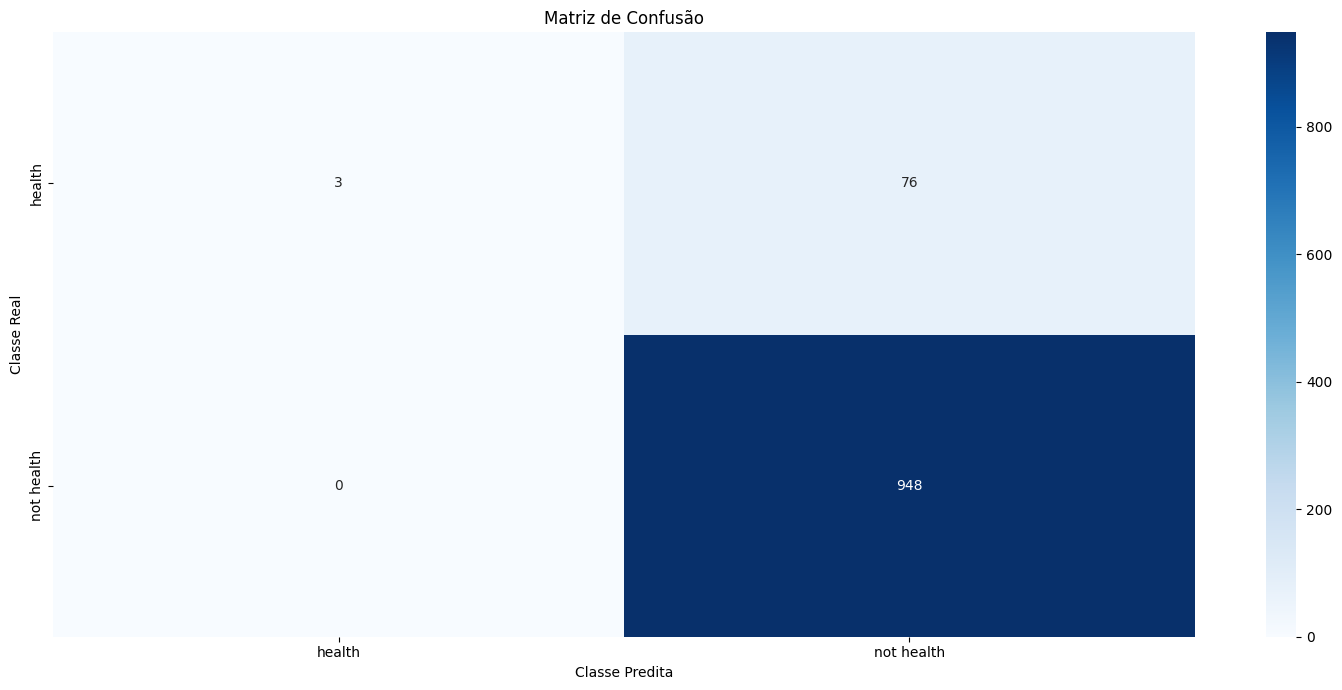

Accuracy: 92.60%
Precision: 96.29%
Recall: 51.90%
F1 Score: 51.73%
              precision    recall  f1-score   support

      health       1.00      0.04      0.07        79
  not health       0.93      1.00      0.96       948

    accuracy                           0.93      1027
   macro avg       0.96      0.52      0.52      1027
weighted avg       0.93      0.93      0.89      1027

24 features analisadas


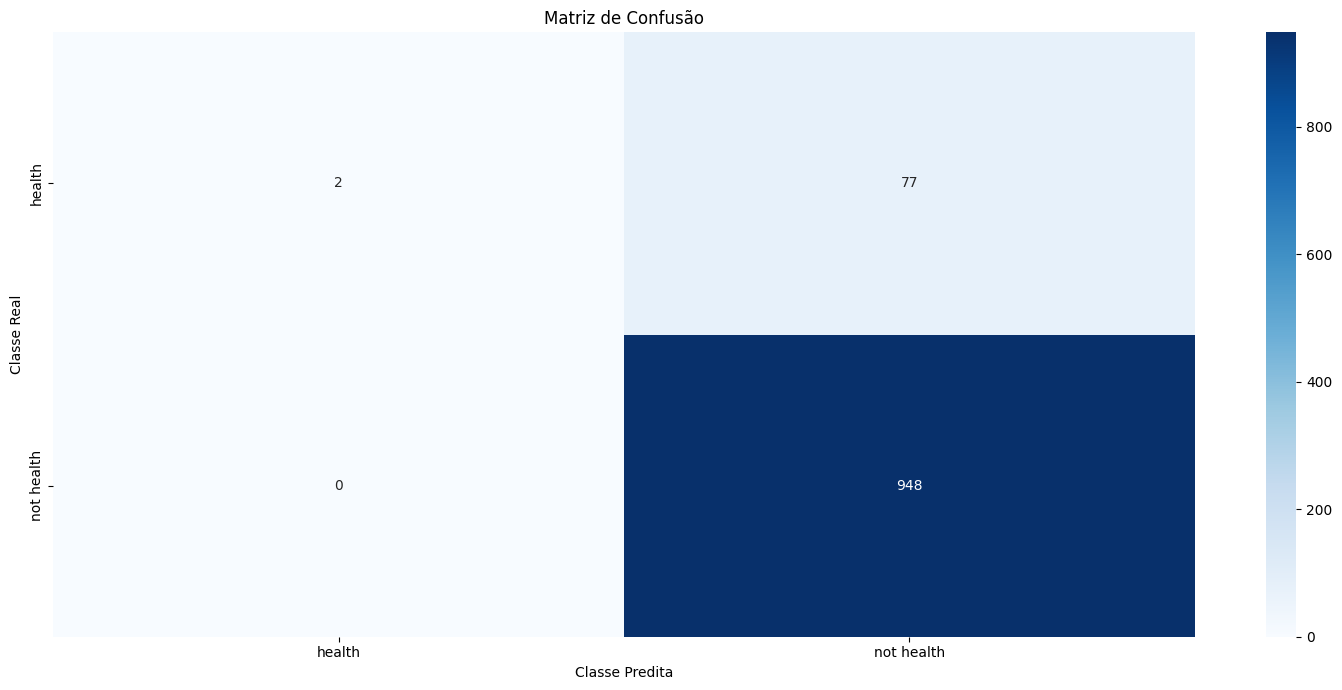

Accuracy: 92.50%
Precision: 96.24%
Recall: 51.27%
F1 Score: 50.52%
              precision    recall  f1-score   support

      health       1.00      0.03      0.05        79
  not health       0.92      1.00      0.96       948

    accuracy                           0.93      1027
   macro avg       0.96      0.51      0.51      1027
weighted avg       0.93      0.93      0.89      1027

25 features analisadas


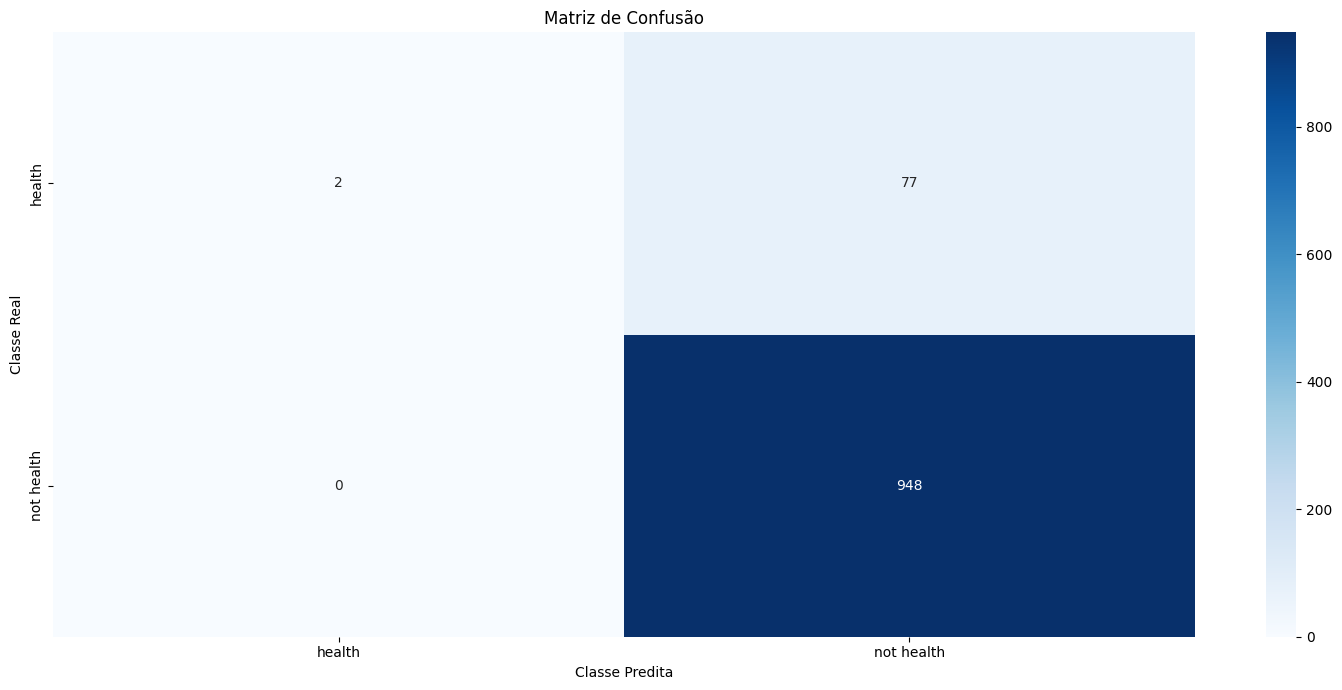

Accuracy: 92.50%
Precision: 96.24%
Recall: 51.27%
F1 Score: 50.52%
              precision    recall  f1-score   support

      health       1.00      0.03      0.05        79
  not health       0.92      1.00      0.96       948

    accuracy                           0.93      1027
   macro avg       0.96      0.51      0.51      1027
weighted avg       0.93      0.93      0.89      1027

26 features analisadas


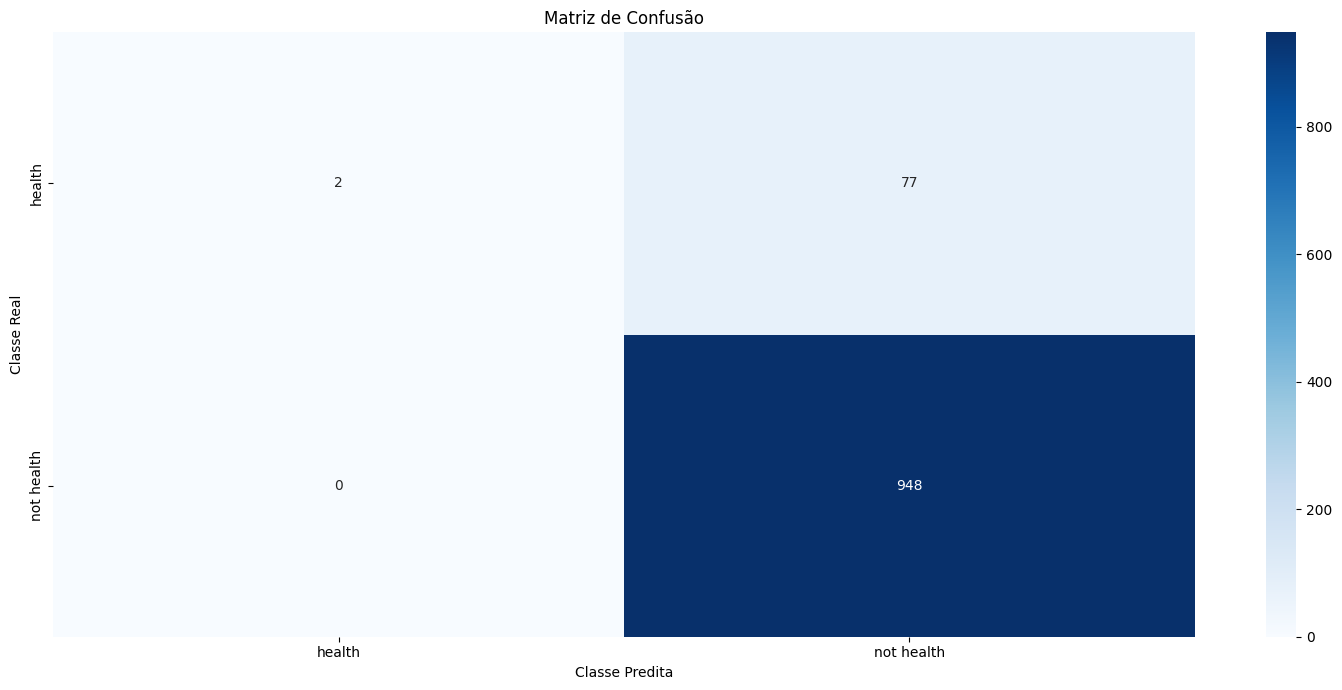

Accuracy: 92.50%
Precision: 96.24%
Recall: 51.27%
F1 Score: 50.52%
              precision    recall  f1-score   support

      health       1.00      0.03      0.05        79
  not health       0.92      1.00      0.96       948

    accuracy                           0.93      1027
   macro avg       0.96      0.51      0.51      1027
weighted avg       0.93      0.93      0.89      1027

27 features analisadas


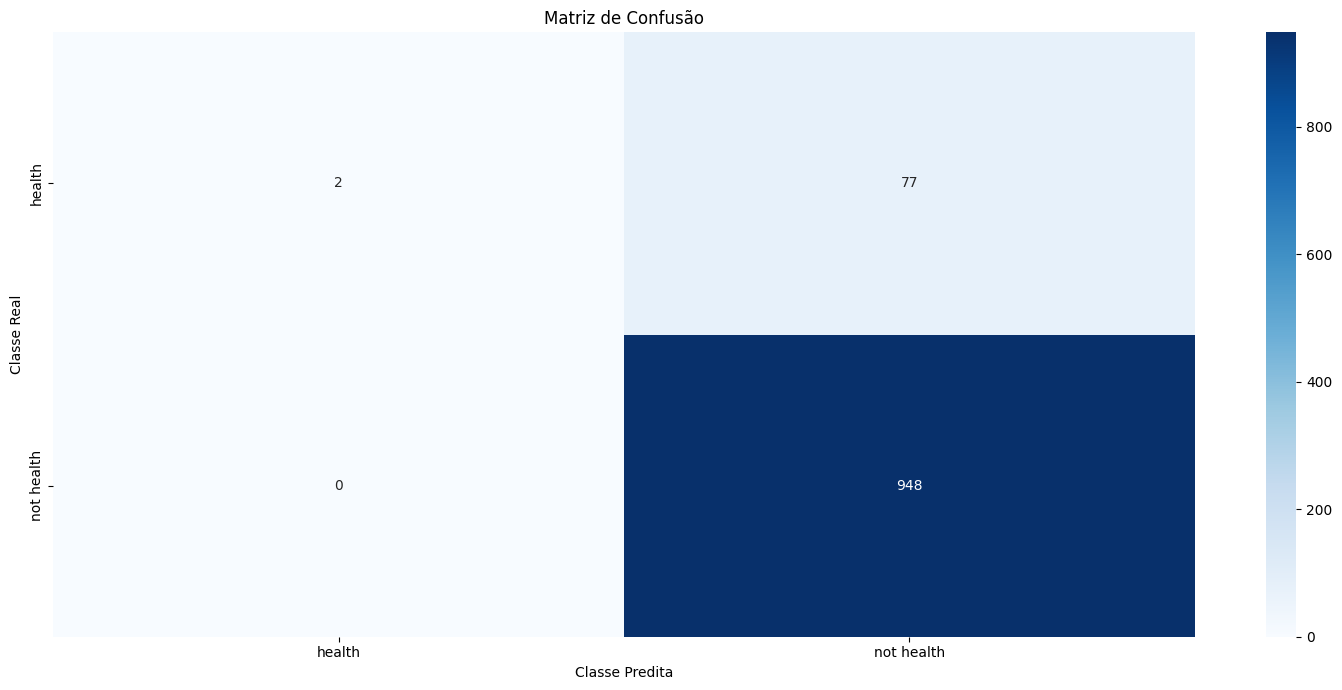

Accuracy: 92.50%
Precision: 96.24%
Recall: 51.27%
F1 Score: 50.52%
              precision    recall  f1-score   support

      health       1.00      0.03      0.05        79
  not health       0.92      1.00      0.96       948

    accuracy                           0.93      1027
   macro avg       0.96      0.51      0.51      1027
weighted avg       0.93      0.93      0.89      1027

28 features analisadas


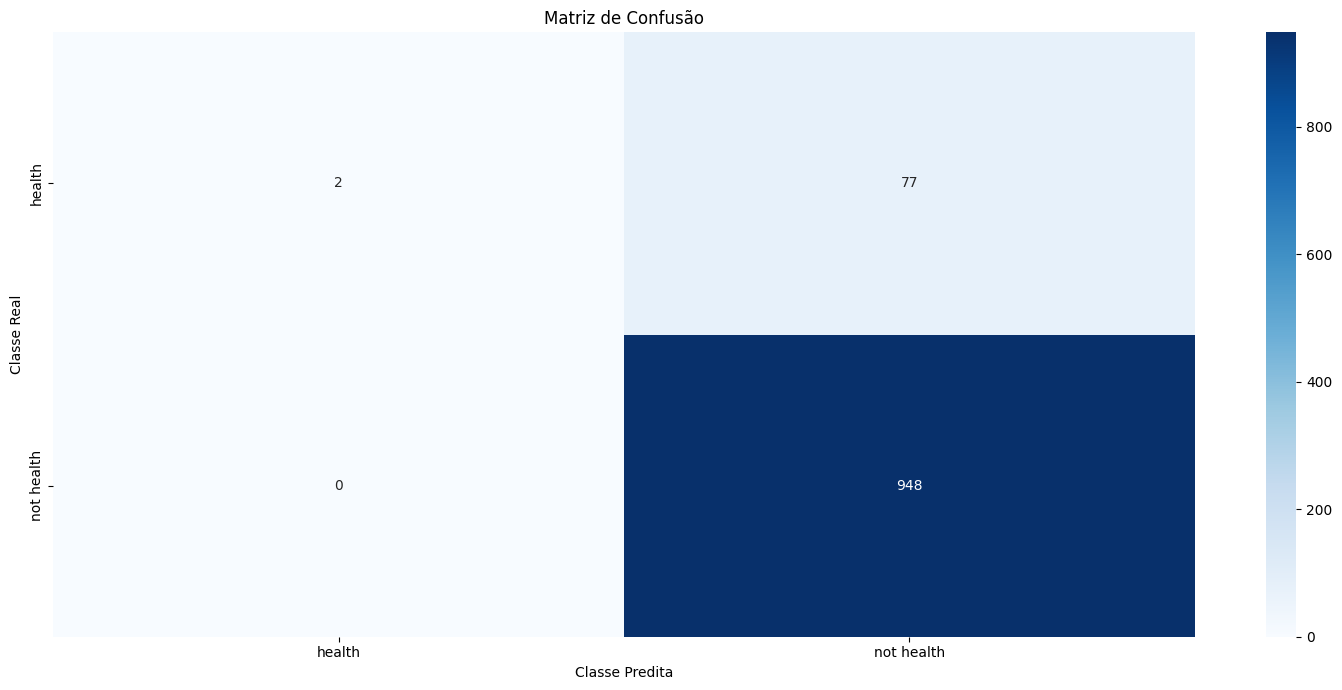

Accuracy: 92.50%
Precision: 96.24%
Recall: 51.27%
F1 Score: 50.52%
              precision    recall  f1-score   support

      health       1.00      0.03      0.05        79
  not health       0.92      1.00      0.96       948

    accuracy                           0.93      1027
   macro avg       0.96      0.51      0.51      1027
weighted avg       0.93      0.93      0.89      1027

29 features analisadas


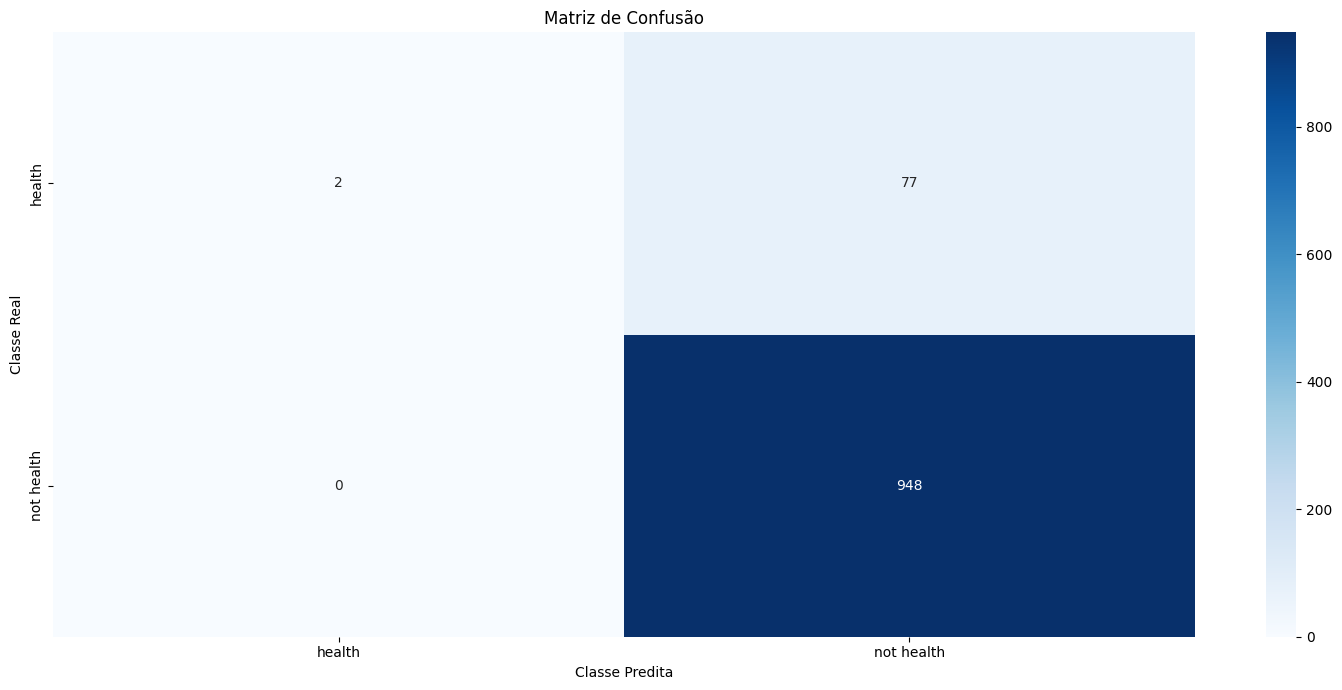

Accuracy: 92.50%
Precision: 96.24%
Recall: 51.27%
F1 Score: 50.52%
              precision    recall  f1-score   support

      health       1.00      0.03      0.05        79
  not health       0.92      1.00      0.96       948

    accuracy                           0.93      1027
   macro avg       0.96      0.51      0.51      1027
weighted avg       0.93      0.93      0.89      1027

30 features analisadas


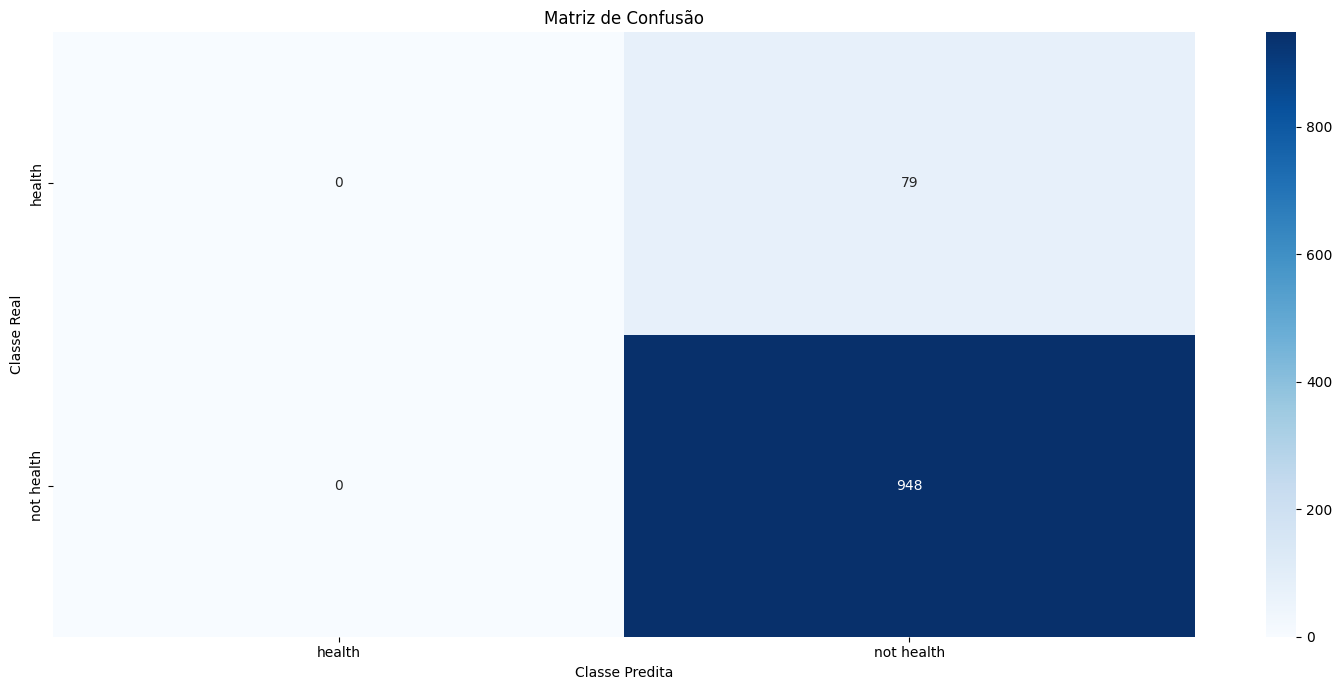

Accuracy: 92.31%
Precision: 46.15%
Recall: 50.00%
F1 Score: 48.00%
              precision    recall  f1-score   support

      health       0.00      0.00      0.00        79
  not health       0.92      1.00      0.96       948

    accuracy                           0.92      1027
   macro avg       0.46      0.50      0.48      1027
weighted avg       0.85      0.92      0.89      1027

31 features analisadas


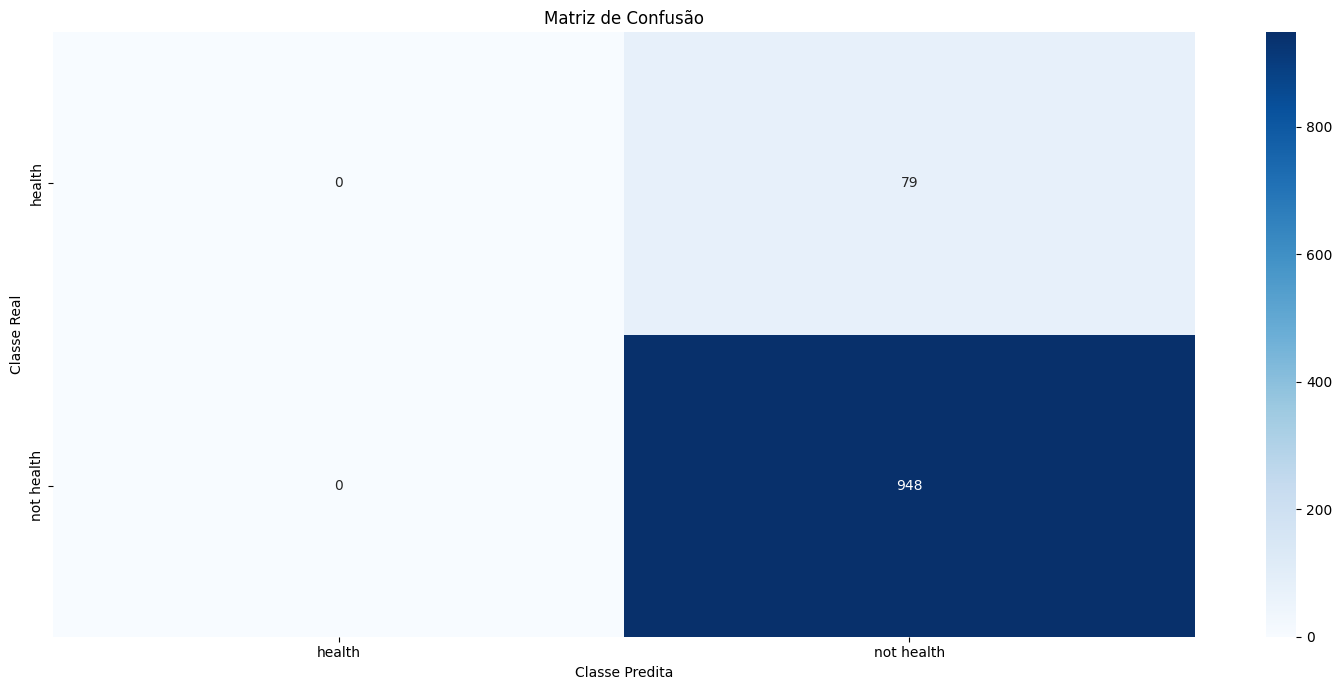

Accuracy: 92.31%
Precision: 46.15%
Recall: 50.00%
F1 Score: 48.00%
              precision    recall  f1-score   support

      health       0.00      0.00      0.00        79
  not health       0.92      1.00      0.96       948

    accuracy                           0.92      1027
   macro avg       0.46      0.50      0.48      1027
weighted avg       0.85      0.92      0.89      1027

32 features analisadas


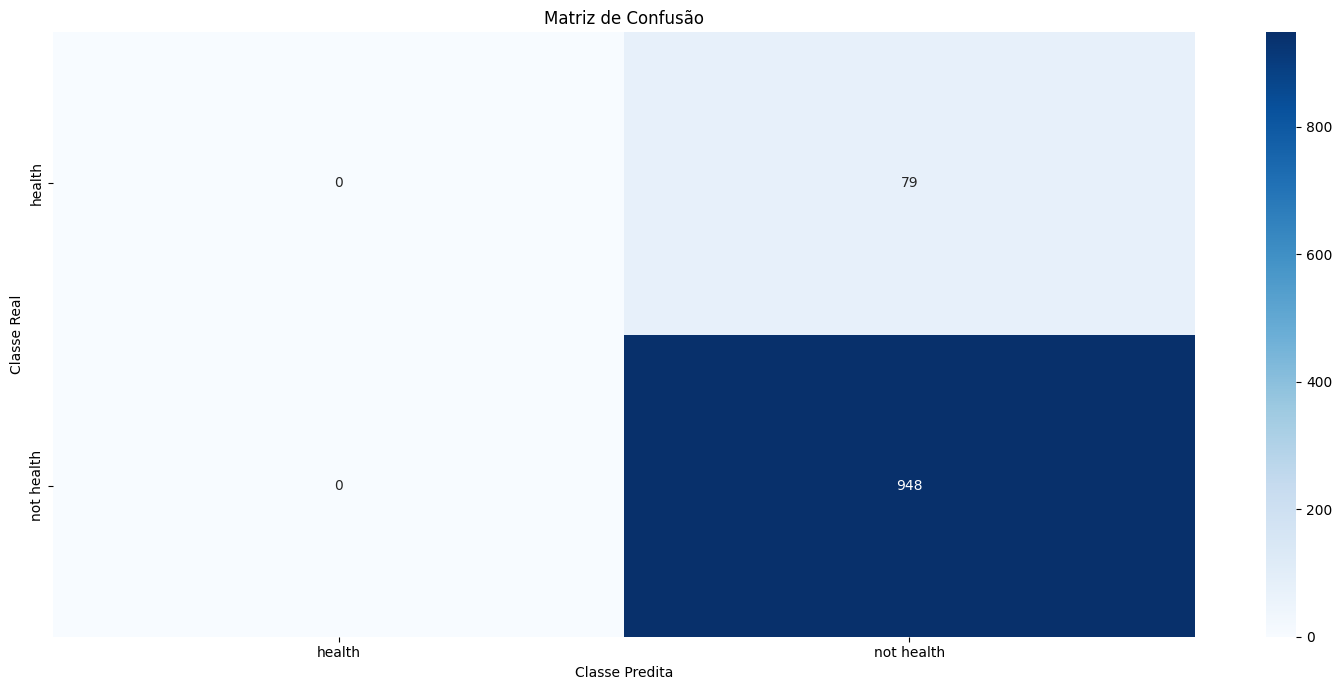

Accuracy: 92.31%
Precision: 46.15%
Recall: 50.00%
F1 Score: 48.00%
              precision    recall  f1-score   support

      health       0.00      0.00      0.00        79
  not health       0.92      1.00      0.96       948

    accuracy                           0.92      1027
   macro avg       0.46      0.50      0.48      1027
weighted avg       0.85      0.92      0.89      1027

33 features analisadas


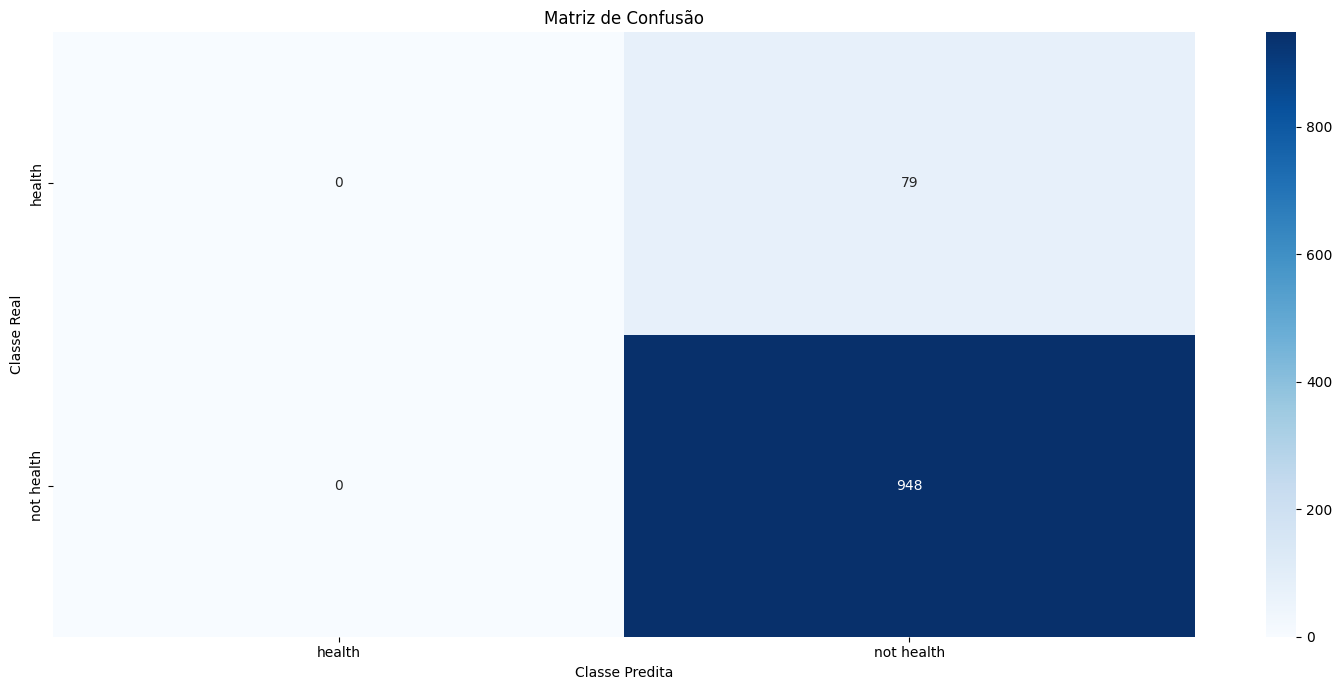

Accuracy: 92.31%
Precision: 46.15%
Recall: 50.00%
F1 Score: 48.00%
              precision    recall  f1-score   support

      health       0.00      0.00      0.00        79
  not health       0.92      1.00      0.96       948

    accuracy                           0.92      1027
   macro avg       0.46      0.50      0.48      1027
weighted avg       0.85      0.92      0.89      1027

33 features analisadas


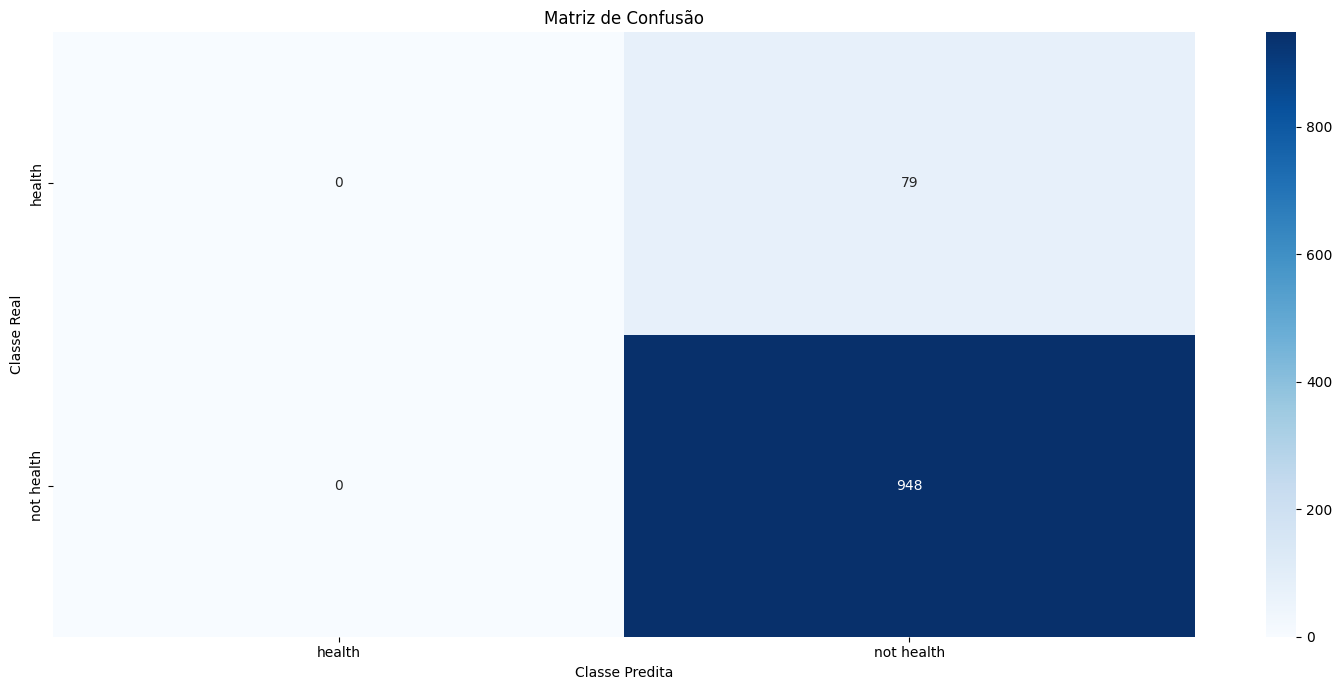

Accuracy: 92.31%
Precision: 46.15%
Recall: 50.00%
F1 Score: 48.00%
              precision    recall  f1-score   support

      health       0.00      0.00      0.00        79
  not health       0.92      1.00      0.96       948

    accuracy                           0.92      1027
   macro avg       0.46      0.50      0.48      1027
weighted avg       0.85      0.92      0.89      1027

33 features analisadas


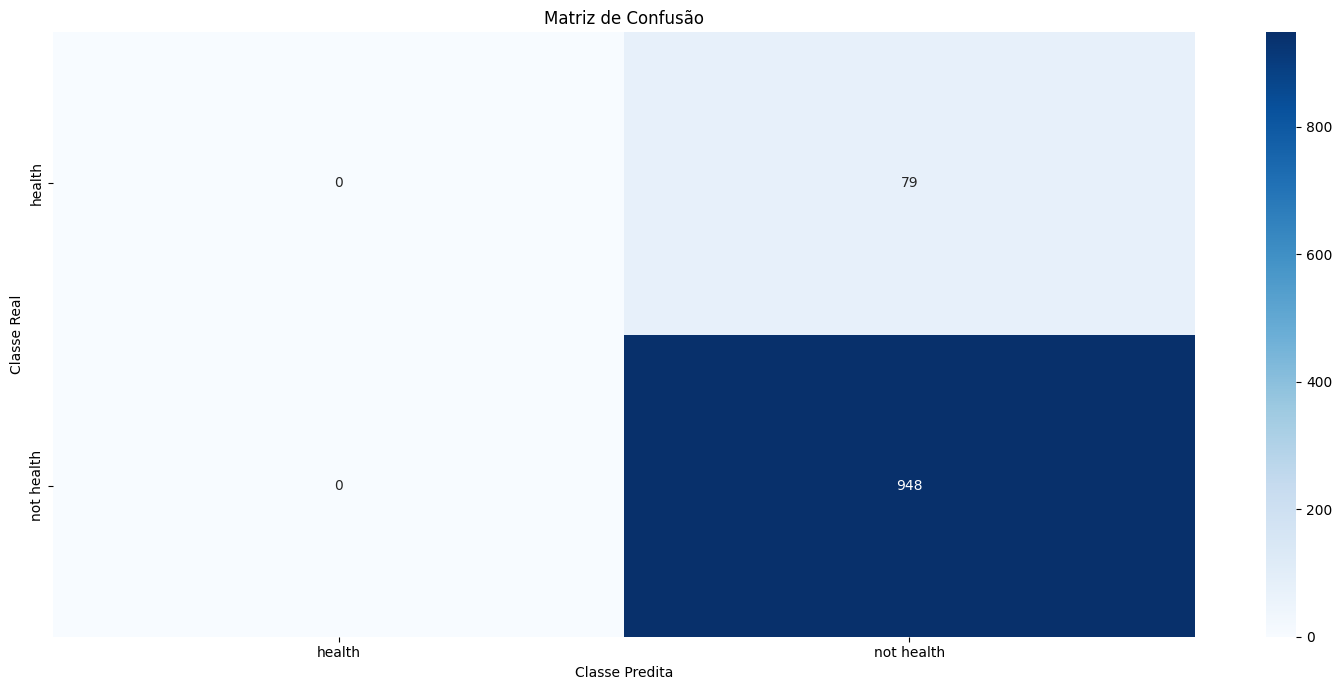

Accuracy: 92.31%
Precision: 46.15%
Recall: 50.00%
F1 Score: 48.00%
              precision    recall  f1-score   support

      health       0.00      0.00      0.00        79
  not health       0.92      1.00      0.96       948

    accuracy                           0.92      1027
   macro avg       0.46      0.50      0.48      1027
weighted avg       0.85      0.92      0.89      1027

33 features analisadas


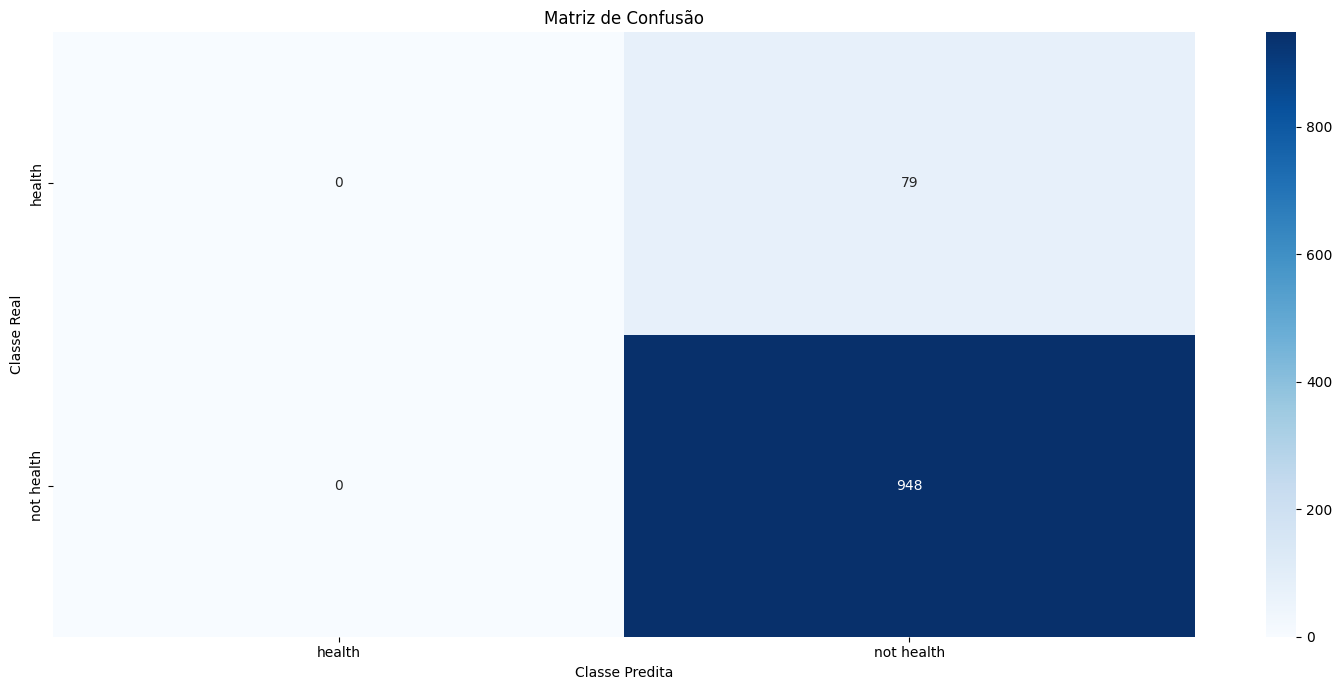

Accuracy: 92.31%
Precision: 46.15%
Recall: 50.00%
F1 Score: 48.00%
              precision    recall  f1-score   support

      health       0.00      0.00      0.00        79
  not health       0.92      1.00      0.96       948

    accuracy                           0.92      1027
   macro avg       0.46      0.50      0.48      1027
weighted avg       0.85      0.92      0.89      1027

33 features analisadas


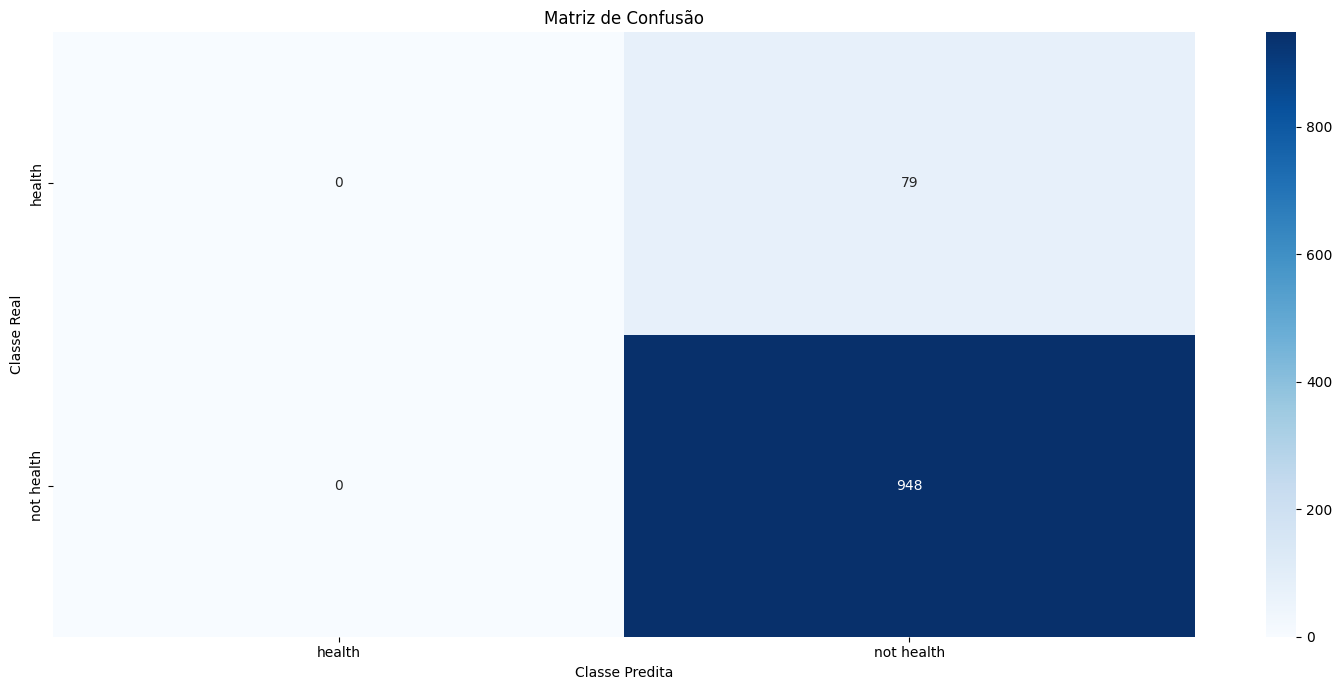

Accuracy: 92.31%
Precision: 46.15%
Recall: 50.00%
F1 Score: 48.00%
              precision    recall  f1-score   support

      health       0.00      0.00      0.00        79
  not health       0.92      1.00      0.96       948

    accuracy                           0.92      1027
   macro avg       0.46      0.50      0.48      1027
weighted avg       0.85      0.92      0.89      1027

33 features analisadas


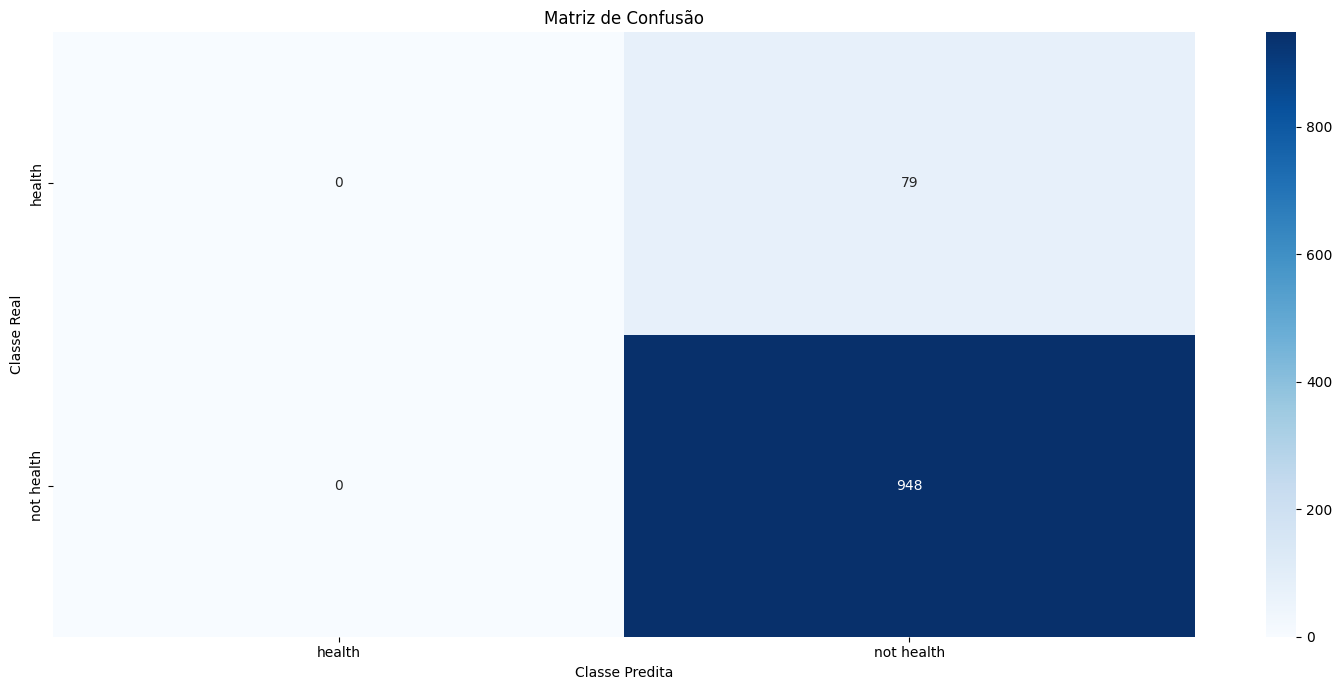

Accuracy: 92.31%
Precision: 46.15%
Recall: 50.00%
F1 Score: 48.00%
              precision    recall  f1-score   support

      health       0.00      0.00      0.00        79
  not health       0.92      1.00      0.96       948

    accuracy                           0.92      1027
   macro avg       0.46      0.50      0.48      1027
weighted avg       0.85      0.92      0.89      1027

33 features analisadas


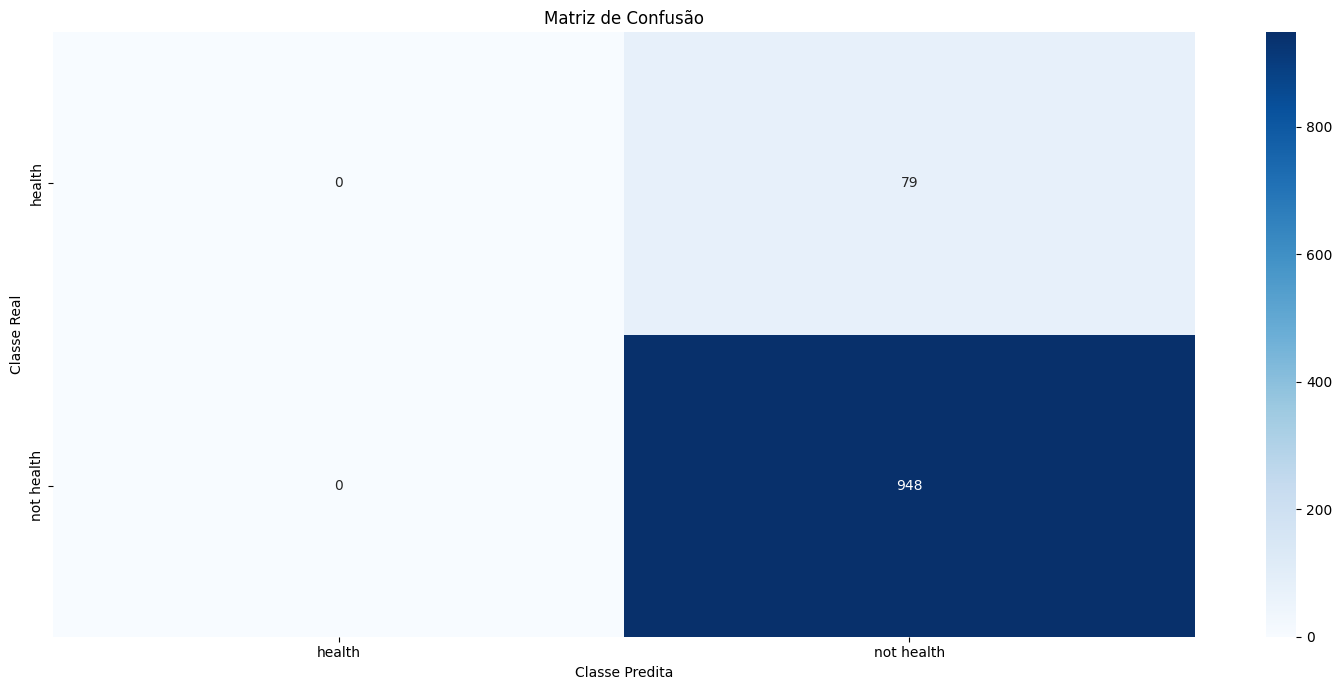

Accuracy: 92.31%
Precision: 46.15%
Recall: 50.00%
F1 Score: 48.00%
              precision    recall  f1-score   support

      health       0.00      0.00      0.00        79
  not health       0.92      1.00      0.96       948

    accuracy                           0.92      1027
   macro avg       0.46      0.50      0.48      1027
weighted avg       0.85      0.92      0.89      1027

33 features analisadas


In [21]:
for n in range(1,41):
    df_features_resposta = gerar_features_resposta_treino(n)
    df_features_resposta_t = gerar_features_resposta_teste(n) #melhor = 7
    evaluate_model(df_features_resposta_t)

Pedido para iterar a função acima e plotar

In [22]:
#evaluate_model_f1score(df_features_resposta)

## DEMONSTRAÇÃO OVERFITTING APÓS 10 FEATURES
Não vou otimizar o número de features, foi escolhido como escopo do projeto 10 features e vou manter
- posso comentar que idealmente usaria um conjunto de validação para escolher o número ideal de features

Melhor resultado encontrado foi o f1-score para 10 features = 63%

[0.41529335912314636, 0.6805591222425313, 0.6896927793896742, 0.6896927793896742, 0.8049930354655523, 0.8218370049355965, 1.0, 1.0, 1.0]
[0.4216281621790354, 0.5753770208358566, 0.5783629197125294, 0.5783629197125294, 0.7465454507103157, 0.7564263951982194, 0.9635929213578741, 0.9597009228442295, 0.9597009228442295]


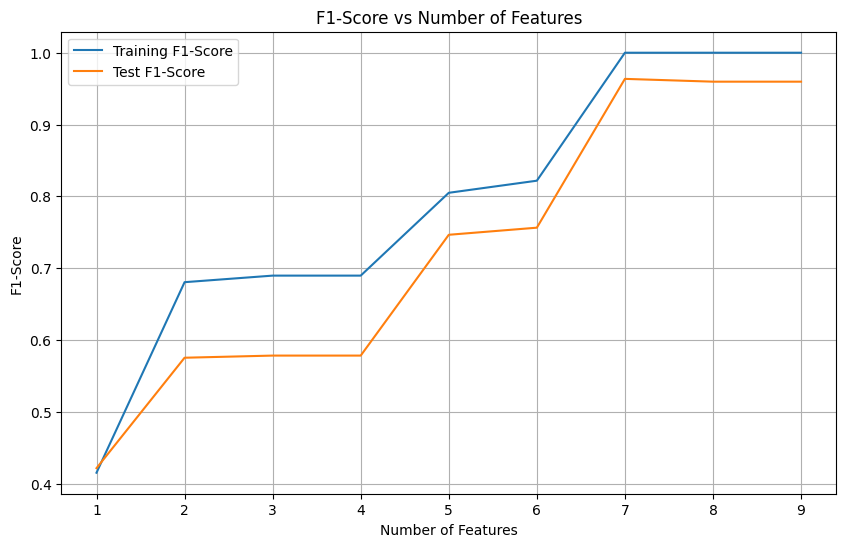

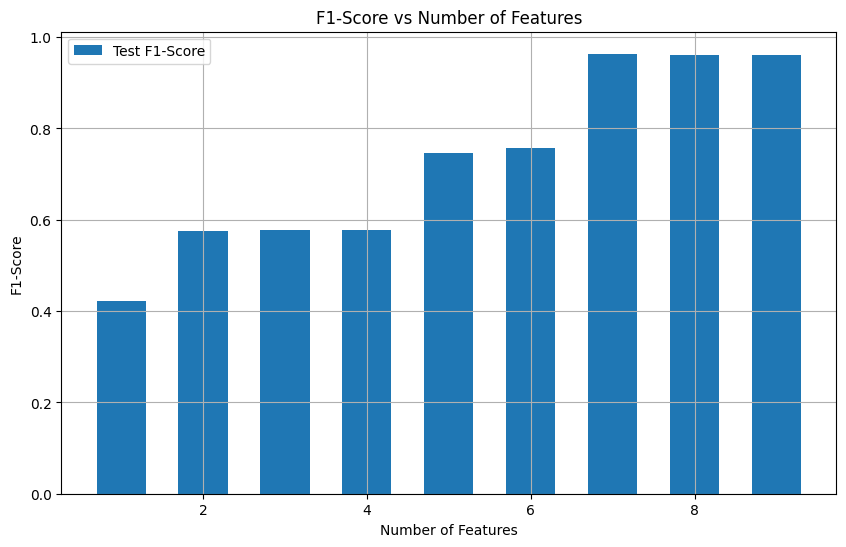

In [23]:
# Function to evaluate model and return F1-score
def evaluate_model_f1score(features_resposta):
    y_true = features_resposta['Fault']
    y_pred = features_resposta['Resposta SE']
    labels = ['health', 'not health']
    
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    
    # Calculate F1-score
    f1 = f1_score(y_true, y_pred, pos_label='health',average='macro') #revisar isso  se não é 'not health'
    
    return f1

# Loop through number of features from 1 to 40 and evaluate F1-scores
def evaluate_feature_selection():
    num_features_range = range(1, 10)
    f1_scores_train = []
    f1_scores_test = []

    for num_features in num_features_range:
        # Get training and test data
        df_features_resposta = gerar_features_resposta_treino(num_features)  # Replace with your actual training data function
        df_features_resposta_t = gerar_features_resposta_teste(num_features)  # Replace with your actual test data function
        
        # Evaluate the model on training data
        f1_train = evaluate_model_f1score(df_features_resposta)
        f1_scores_train.append(f1_train)
        
        # Evaluate the model on test data
        f1_test = evaluate_model_f1score(df_features_resposta_t)
        f1_scores_test.append(f1_test)
    print(f1_scores_train)
    print(f1_scores_test)
    
    # Plotting F1-Score comparison
    plt.figure(figsize=(10, 6))
    plt.plot(num_features_range, f1_scores_train, label='Training F1-Score')
    plt.plot(num_features_range, f1_scores_test, label='Test F1-Score')
    plt.xlabel('Number of Features')
    plt.ylabel('F1-Score')
    plt.title('F1-Score vs Number of Features')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.bar(num_features_range, f1_scores_test, width=0.6, label='Test F1-Score')
    plt.xlabel('Number of Features')
    plt.ylabel('F1-Score')
    plt.title('F1-Score vs Number of Features')
    plt.legend()
    plt.grid(True)
    plt.show()
    

# Example usage
evaluate_feature_selection()

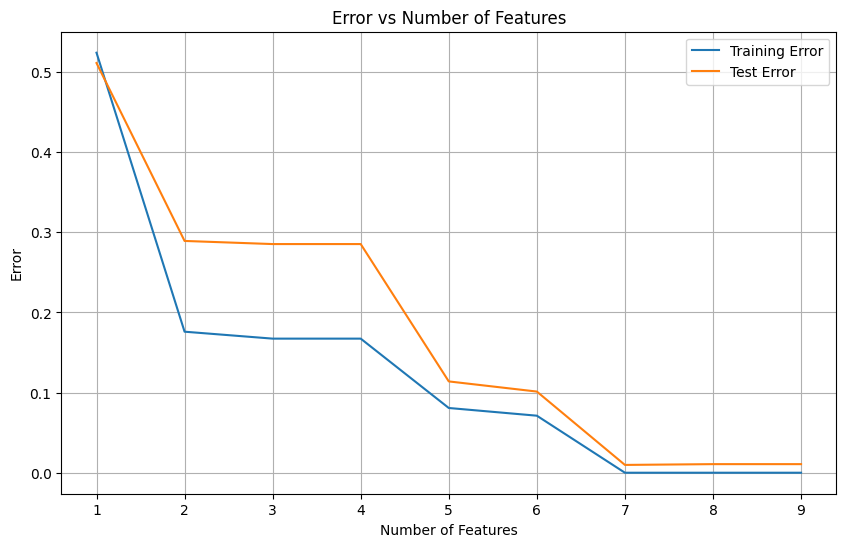

In [24]:
def evaluate_model_error(features_resposta):
    y_true = features_resposta['Fault']
    y_pred = features_resposta['Resposta SE']
    labels = ['health', 'not health']
    
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    
    # Calculate error
    error = 1 - np.trace(cm) / np.sum(cm)
    
    return error

# Loop through number of features from 1 to 40 and evaluate errors
def evaluate_feature_selection_error():
    num_features_range = range(1, 10)
    errors_train = []
    errors_test = []

    for num_features in num_features_range:
        # Get training and test data
        df_features_resposta = gerar_features_resposta_treino(num_features)  # Replace with your actual training data function
        df_features_resposta_t = gerar_features_resposta_teste(num_features)  # Replace with your actual test data function
        
        # Ensure the returned DataFrame is not None
        if df_features_resposta is None or df_features_resposta_t is None:
            print(f"executar_teste returned None for num_features={num_features}")
            continue
        
        # Evaluate the model on training data
        error_train = evaluate_model_error(df_features_resposta)
        errors_train.append(error_train)
        
        # Evaluate the model on test data
        error_test = evaluate_model_error(df_features_resposta_t)
        errors_test.append(error_test)

    # Plotting error comparison
    plt.figure(figsize=(10, 6))
    plt.plot(num_features_range, errors_train, label='Training Error')
    plt.plot(num_features_range, errors_test, label='Test Error')
    plt.xlabel('Number of Features')
    plt.ylabel('Error')
    plt.title('Error vs Number of Features')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
evaluate_feature_selection_error()

[0.128, 0.3041825095057034, 0.31496062992125984, 0.31496062992125984, 0.4878048780487805, 0.5194805194805194, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.12709030100334448, 0.20380434782608695, 0.20604395604395603, 0.20604395604395603, 0.3978494623655914, 0.4233128834355828, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


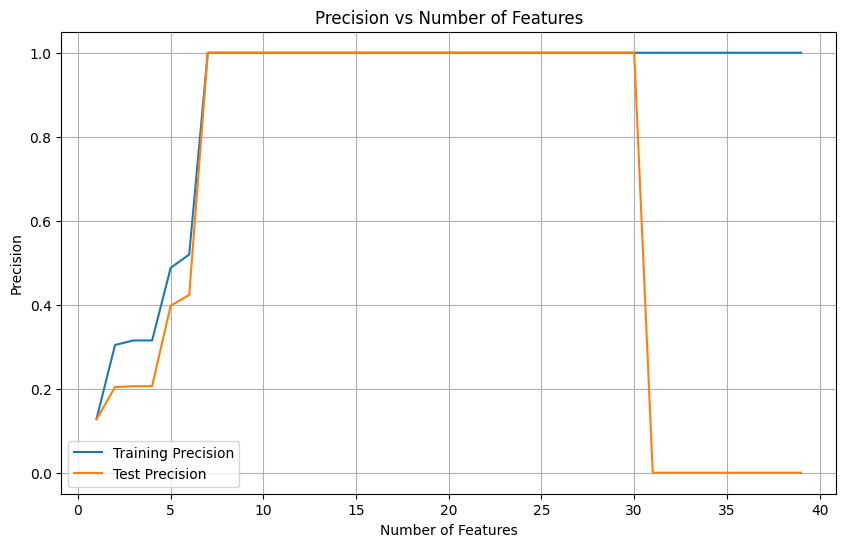

In [25]:

# Function to evaluate model and return Precision
def evaluate_model_precision(features_resposta):
    y_true = features_resposta['Fault']
    y_pred = features_resposta['Resposta SE']
    labels = ['health', 'not health']
    
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    
    # Calculate Precision
    precision = precision_score(y_true, y_pred, pos_label='health')  # Ensure 'health' is the correct positive label
    
    return precision

# Loop through number of features from 1 to 40 and evaluate Precision scores
def evaluate_feature_selection_precision():
    num_features_range = range(1, 40)
    precision_scores_train = []
    precision_scores_test = []

    for num_features in num_features_range:
        # Get training and test data
        df_features_resposta = gerar_features_resposta_treino(num_features)  # Replace with your actual training data function
        df_features_resposta_t = gerar_features_resposta_teste(num_features)  # Replace with your actual test data function
        
        # Evaluate the model on training data
        precision_train = evaluate_model_precision(df_features_resposta)
        precision_scores_train.append(precision_train)
        
        # Evaluate the model on test data
        precision_test = evaluate_model_precision(df_features_resposta_t)
        precision_scores_test.append(precision_test)
    
    print(precision_scores_train)
    print(precision_scores_test)
    
    # Plotting Precision Score comparison
    plt.figure(figsize=(10, 6))
    plt.plot(num_features_range, precision_scores_train, label='Training Precision')
    plt.plot(num_features_range, precision_scores_test, label='Test Precision')
    plt.xlabel('Number of Features')
    plt.ylabel('Precision')
    plt.title('Precision vs Number of Features')
    plt.legend()
    plt.grid(True)
    plt.show()
    

# Example usage
evaluate_feature_selection_precision()

# Confusion Matrix na Mão 10 e 20 Nm
- soma das cm de 10 e 20Nm

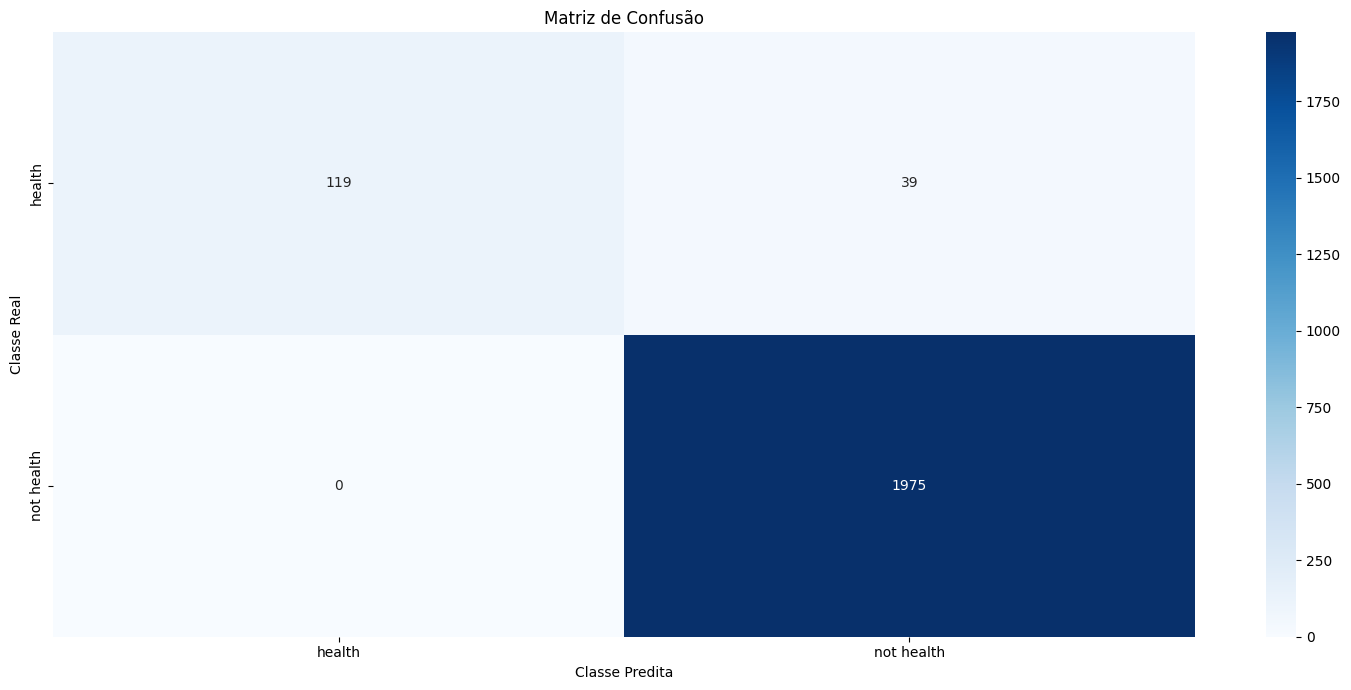

In [26]:
labels = ['health', 'not health']

# Combined confusion matrix values
cm_combined = np.array([[119, 39], [0, 1975]])

# Plotting the confusion matrix with specified formatting
fig, ax = plt.subplots(figsize=(15, 7))

# Plot the confusion matrix
sns.heatmap(cm_combined, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)
ax.set_xlabel('Classe Predita')
ax.set_ylabel('Classe Real')
ax.set_title('Matriz de Confusão')

plt.tight_layout()
plt.show()

In [29]:
# Calculate precision, recall, and F1 score for each class manually

# For 10Nm
precision_10Nm_health = 50 / (50 + 29)
recall_10Nm_health = 50 / (50 + 0)
f1_score_10Nm_health = 2 * (precision_10Nm_health * recall_10Nm_health) / (precision_10Nm_health + recall_10Nm_health)

precision_10Nm_not_health = 1027 / (1027 + 0)
recall_10Nm_not_health = 1027 / (1027 + 29)
f1_score_10Nm_not_health = 2 * (precision_10Nm_not_health * recall_10Nm_not_health) / (precision_10Nm_not_health + recall_10Nm_not_health)

# For 20Nm
precision_20Nm_health = 69 / (69 + 10)
recall_20Nm_health = 69 / (69 + 0)
f1_score_20Nm_health = 2 * (precision_20Nm_health * recall_20Nm_health) / (precision_20Nm_health + recall_20Nm_health)

precision_20Nm_not_health = 948 / (948 + 0)
recall_20Nm_not_health = 948 / (948 + 10)
f1_score_20Nm_not_health = 2 * (precision_20Nm_not_health * recall_20Nm_not_health) / (precision_20Nm_not_health + recall_20Nm_not_health)

# Calculate Macro F1 Scores
macro_f1_10Nm = (f1_score_10Nm_health + f1_score_10Nm_not_health) / 2
macro_f1_20Nm = (f1_score_20Nm_health + f1_score_20Nm_not_health) / 2

# Calculate Combined Macro F1 Score
combined_macro_f1 = (macro_f1_10Nm + macro_f1_20Nm) / 2

macro_f1_10Nm, macro_f1_20Nm, combined_macro_f1

(0.8806357854466017, 0.9635929213578741, 0.9221143534022379)